In [179]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs


from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

In [180]:
timeseries_retail_sales= pd.read_csv('/Users/Apple/Downloads/dataDES/retail sales on internet.csv', index_col='date', parse_dates=['date'], dayfirst=False)

In [181]:
timeseries_retail_sales=timeseries_retail_sales.dropna()

In [182]:
timeseries_retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 193 entries, 2006-11-01 to 2022-11-01
Data columns (total 3 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Average weekly value for all retailing (£ million)          193 non-null    float64
 1   Average weekly value for Internet retail sales (£ million)  193 non-null    float64
 2   Internet sales as a percentage of total retail sales (%)    193 non-null    float64
dtypes: float64(3)
memory usage: 6.0 KB


In [183]:
timeseries_retail_sales.index.freq='MS'

In [184]:
df=timeseries_retail_sales.drop(['Average weekly value for all retailing (£ million)', 'Average weekly value for Internet retail sales (£ million)'], axis=1)

In [185]:
df.rename(columns = {'Internet sales as a percentage of total retail sales (%)':'value'}, inplace = True)

In [186]:
df

value
date             
2006-11-01    2.8
2006-12-01    2.5
2007-01-01    2.7
2007-02-01    2.8
2007-03-01    2.9
...           ...
2022-07-01   25.1
2022-08-01   24.4
2022-09-01   25.4
2022-10-01   26.1
2022-11-01   30.2

[193 rows x 1 columns]

In [187]:
data_2019=df. loc['2006-11-01':'2019-12-01'] 

In [188]:
data_2019

value
date             
2006-11-01    2.8
2006-12-01    2.5
2007-01-01    2.7
2007-02-01    2.8
2007-03-01    2.9
...           ...
2019-08-01   18.1
2019-09-01   18.1
2019-10-01   19.1
2019-11-01   21.6
2019-12-01   21.4

[158 rows x 1 columns]

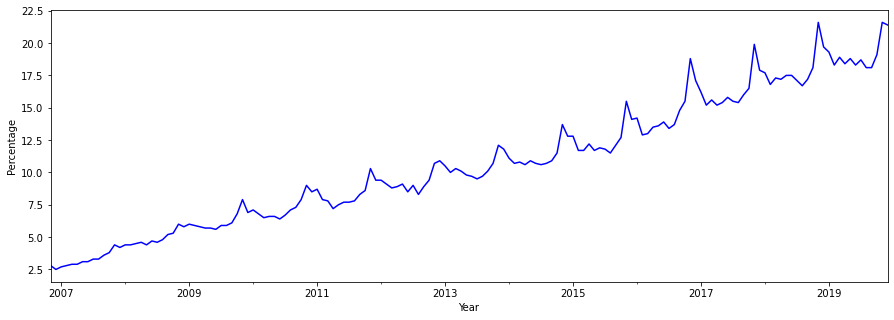

In [189]:
ax=data_2019['value'].plot(figsize=(15,5),color="blue")
#plt.title(' Internet sales as a percentage of total retail sales from 2006-2019' , fontweight="bold", size=24, color='black')
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')


plt.show()

In [ ]:
# testing stationarity


In [190]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data_2019.value.dropna(),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:' ,result[4])

ADF Statistic: 0.755012
p-value: 0.990874
Critical Values: {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}


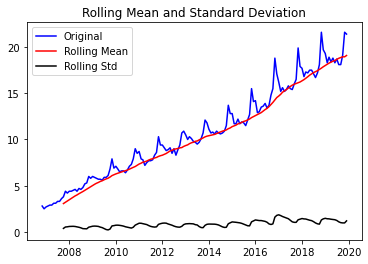

Results of dickey fuller test
Test Statistics                  0.755012
p-value                          0.990874
No. of lags used                14.000000
Number of observations used    143.000000
critical value (1%)             -3.476927
critical value (5%)             -2.881973
critical value (10%)            -2.577665
dtype: float64


In [191]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data_2019)

In [192]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

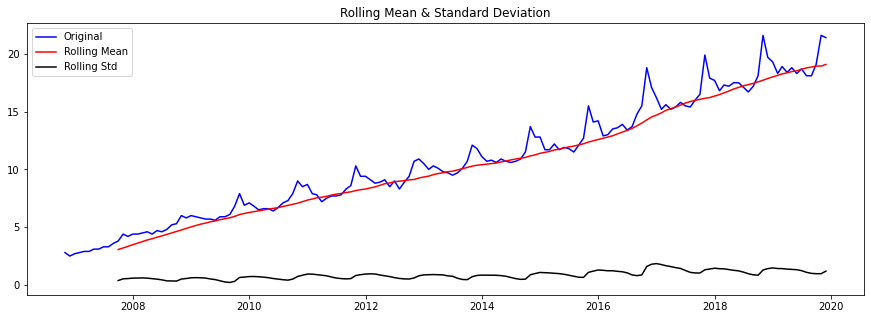

In [193]:
test_stationarity(data_2019['value'])

<Figure size 432x288 with 0 Axes>

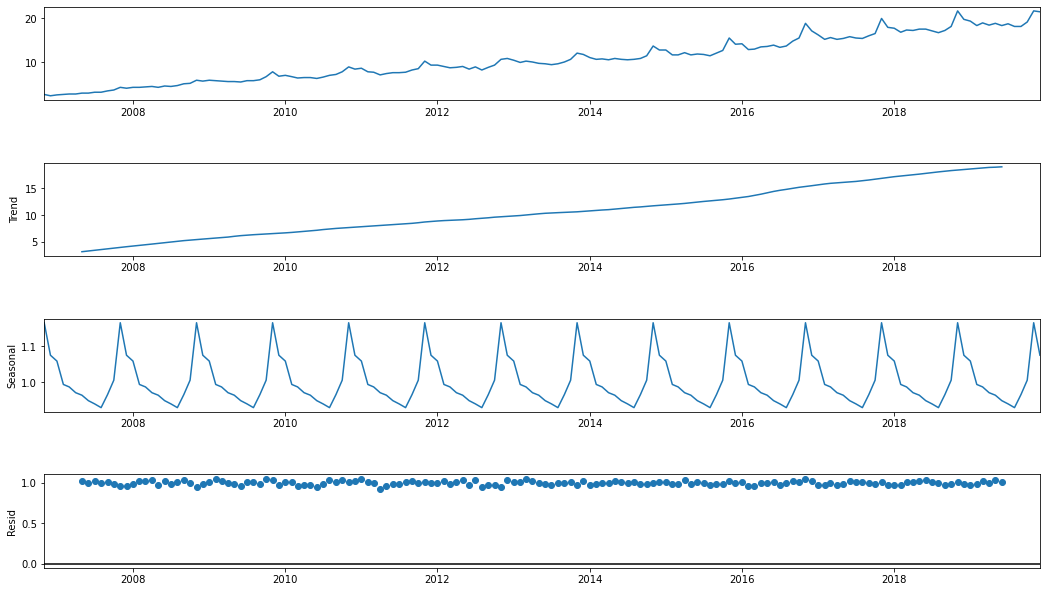

In [194]:

#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(data_2019, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


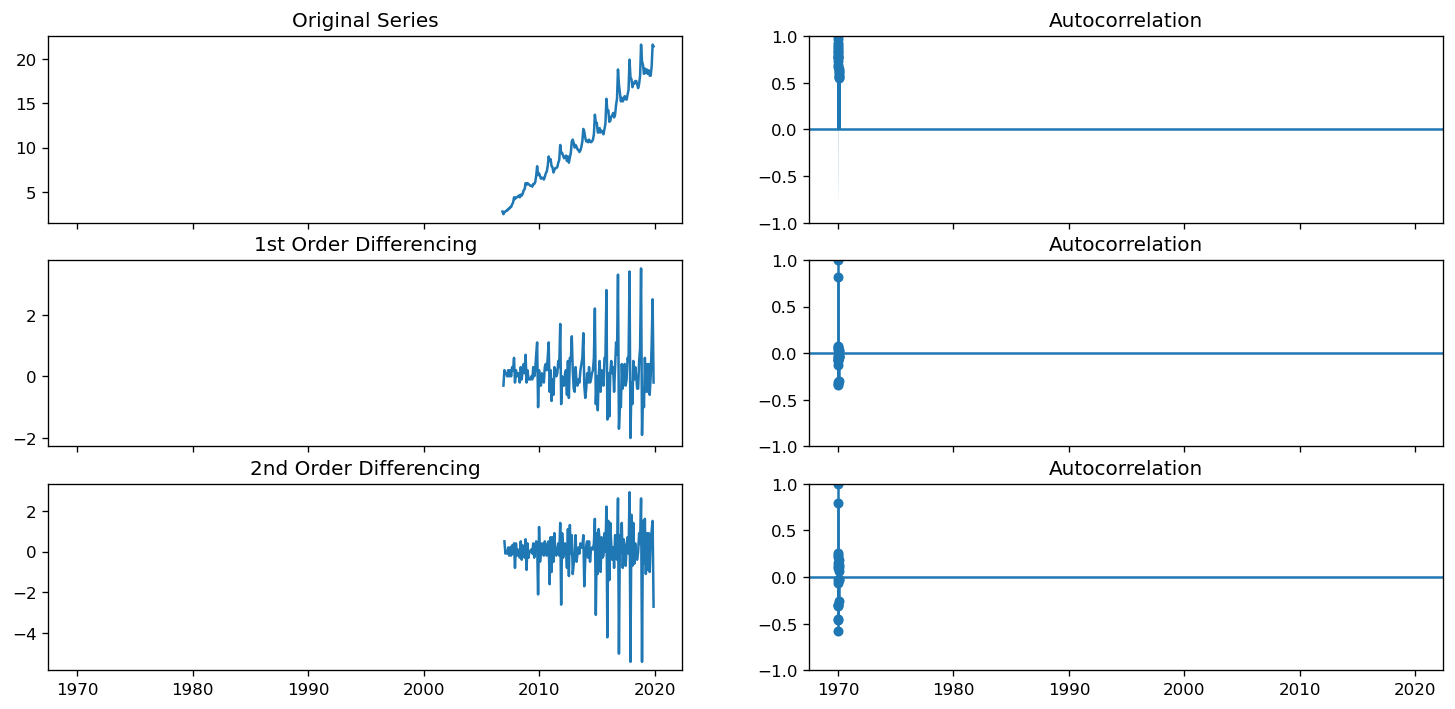

In [195]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_2019.value); axes[0, 0].set_title('Original Series')
plot_acf(data_2019.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_2019.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_2019.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_2019.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_2019.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

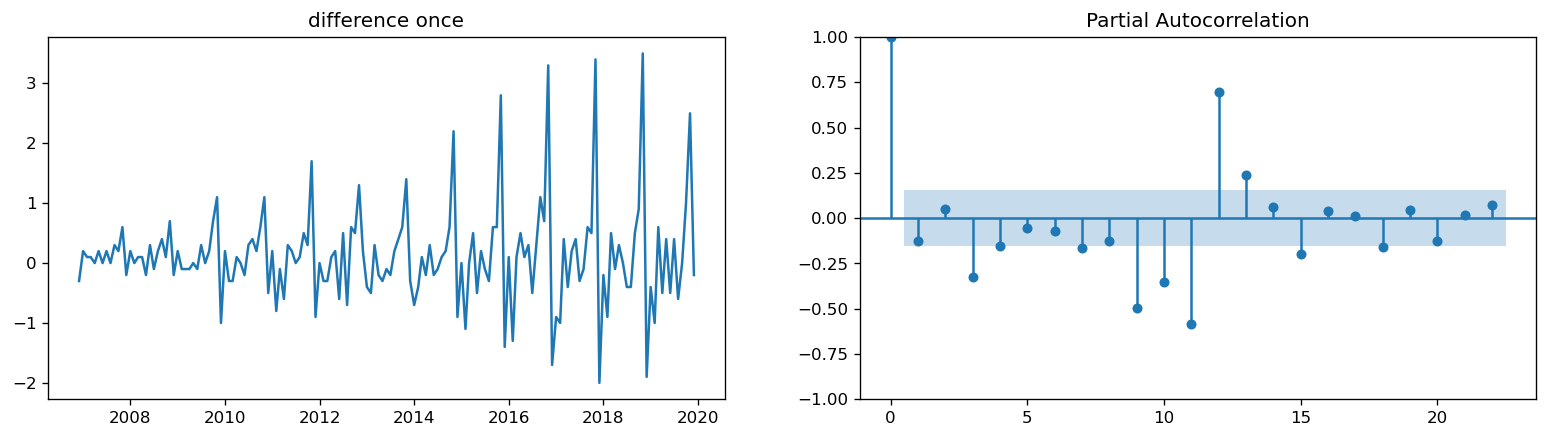

In [196]:
#second difference exterme negitive value so difference only once

#p value
diff=data_2019.value.diff().dropna()

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('difference once')
#ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

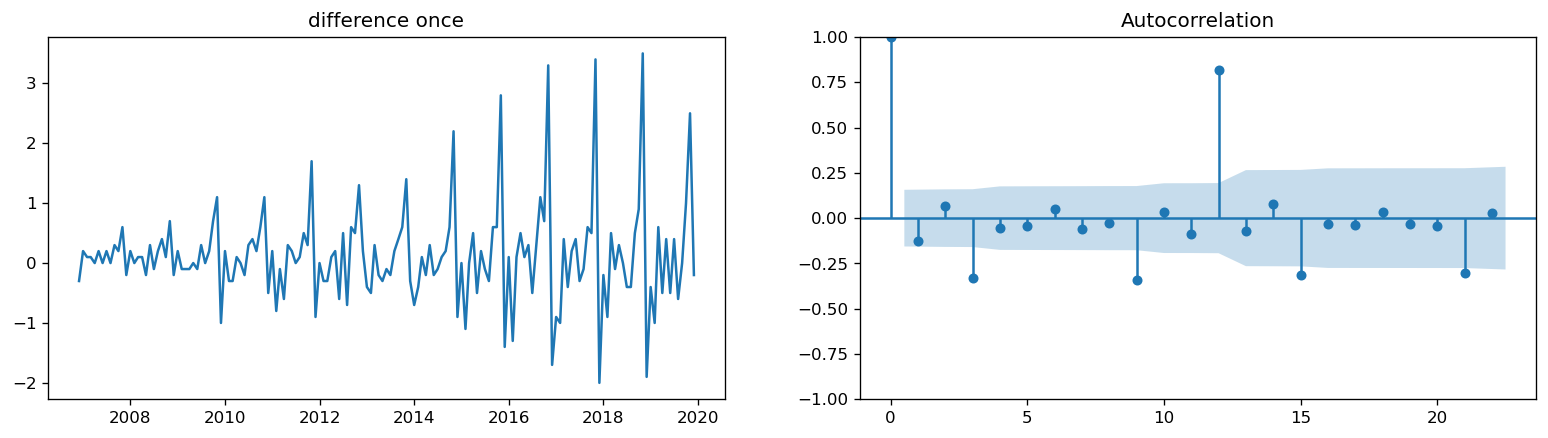

In [197]:
#qvalue

diff=data_2019.value.diff().dropna()

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('difference once')
#ax2.set_ylim(0, 1.2)
plot_acf(diff, ax=ax2);

In [198]:
#automatic ordering
from pmdarima import auto_arima
stepwise_fit = auto_arima(data_2019['value'], trace=True,
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=380.533, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=380.025, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=380.112, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=381.916, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=381.569, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=364.274, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=366.132, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=360.616, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=381.880, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=345.952, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=345.013, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=345.561, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=368.054, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -167.507
Date:                Fri, 06 Jan 2023   AIC                            345.013
Time:                        03:09:15   BIC                            360.294
Sample:                    11-01-2006   HQIC                           351.219
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1099      0.015      7.115      0.000       0.080       0.140
ma.L1         -0.3245      0.100     -3.238      0.001      -0.521      -0.128
ma.L2         -0.0706      0.113     -0.623      0.533      -0.293       0.152
ma.L3         -0.4536      0.120     -3.769      0.000      -0.689      -0.218
sigma2         0.4904      0.045     10.866      0.000       0.402       0.579
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               736.58
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               8.20   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
model = sm.tsa.arima.ARIMA(data_2019.value, order=(0,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  158
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -180.027
Date:                Fri, 06 Jan 2023   AIC                            368.054
Time:                        03:09:20   BIC                            380.279
Sample:                    11-01-2006   HQIC                           373.019
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1433      0.074     -1.926      0.054      -0.289       0.003
ma.L2          0.0647      0.100      0.646      0.518      -0.132       0.261
ma.L3         -0.3428      0.154     -2.223      0.0

In [200]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(data_2019['value'], 
                    
                      test='adf', # use adftest to find optimal 'd'
                    
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      # let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  158
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -184.275
Date:                Fri, 06 Jan 2023   AIC                            376.550
Time:                        03:09:25   BIC                            388.800
Sample:                    11-01-2006   HQIC                           381.525
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0008      0.020      0.039      0.969      -0.038       0.040
ar.L2          0.9967      0.020     50.768      0.000       0.958       1.035
ma.L1          0.9719      0.061     15.981      0.0

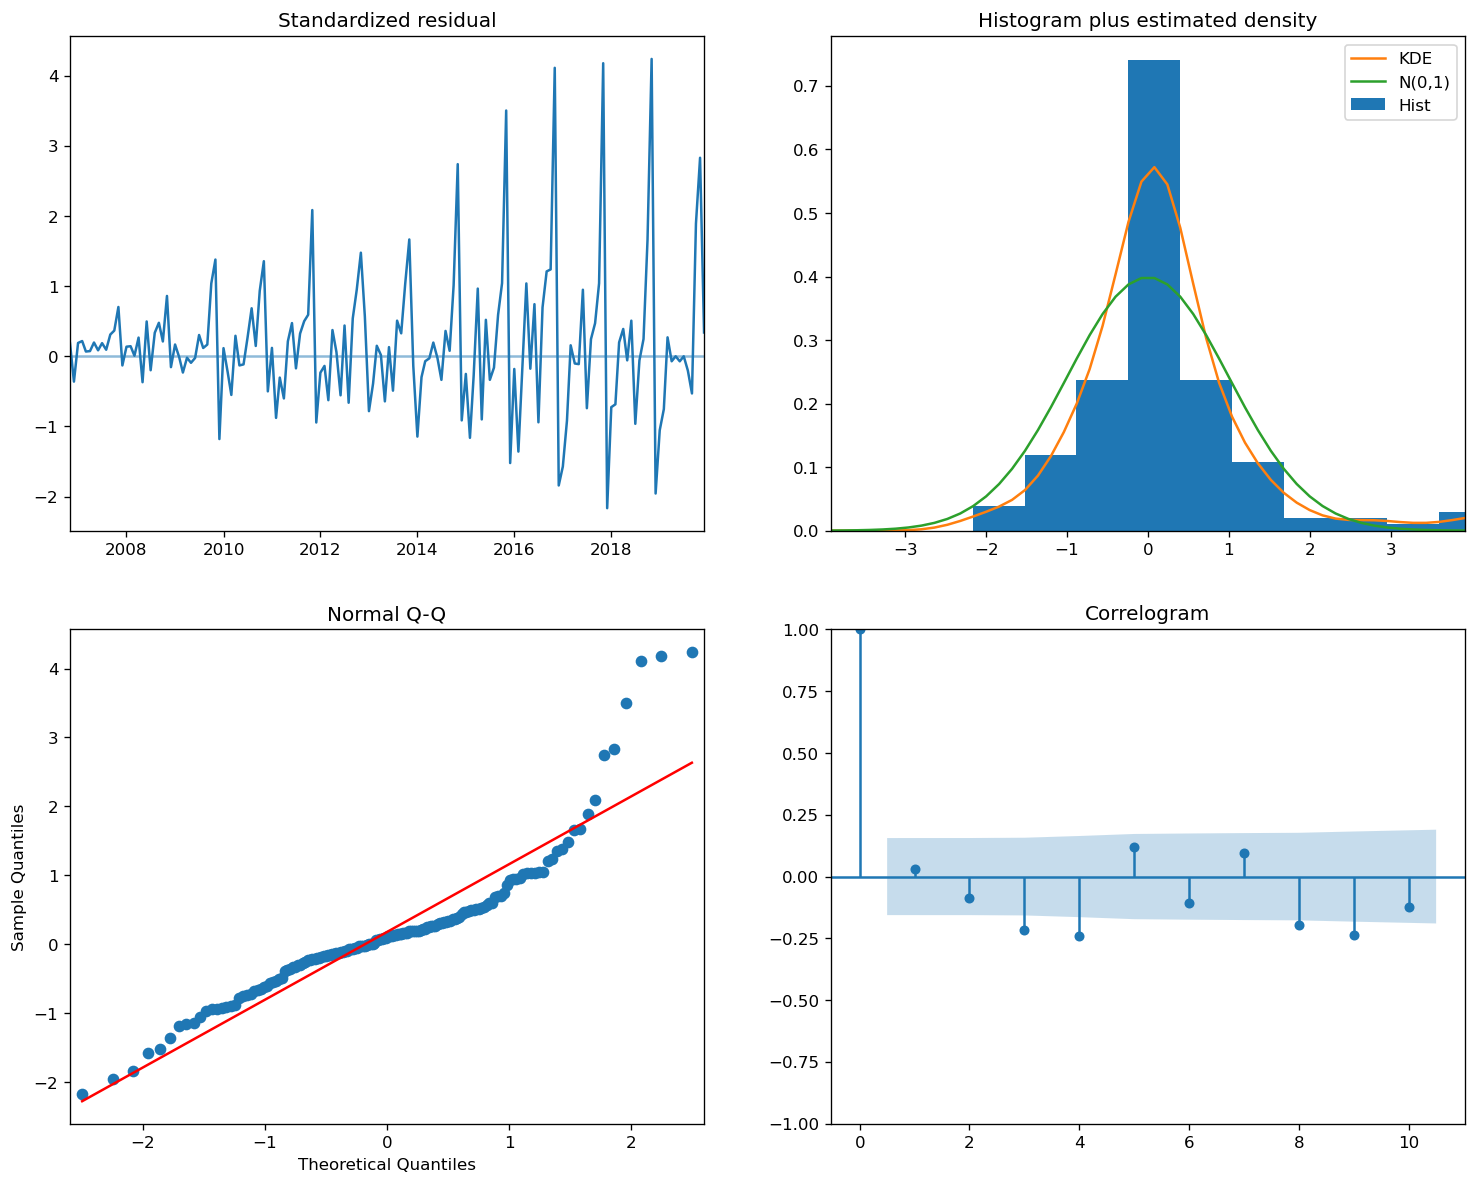

In [201]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
#creating test and training data

In [202]:
n=len(data_2019)
n

158

In [203]:
start_index=n-13
start_index

145

In [204]:
df_train = data_2019.iloc[:start_index] 

In [205]:
df_train

value
date             
2006-11-01    2.8
2006-12-01    2.5
2007-01-01    2.7
2007-02-01    2.8
2007-03-01    2.9
...           ...
2018-07-01   17.1
2018-08-01   16.7
2018-09-01   17.2
2018-10-01   18.1
2018-11-01   21.6

[145 rows x 1 columns]

In [206]:
df_test= data_2019.iloc[start_index:]

In [207]:
df_test

value
date             
2018-12-01   19.7
2019-01-01   19.3
2019-02-01   18.3
2019-03-01   18.9
2019-04-01   18.4
2019-05-01   18.8
2019-06-01   18.3
2019-07-01   18.7
2019-08-01   18.1
2019-09-01   18.1
2019-10-01   19.1
2019-11-01   21.6
2019-12-01   21.4

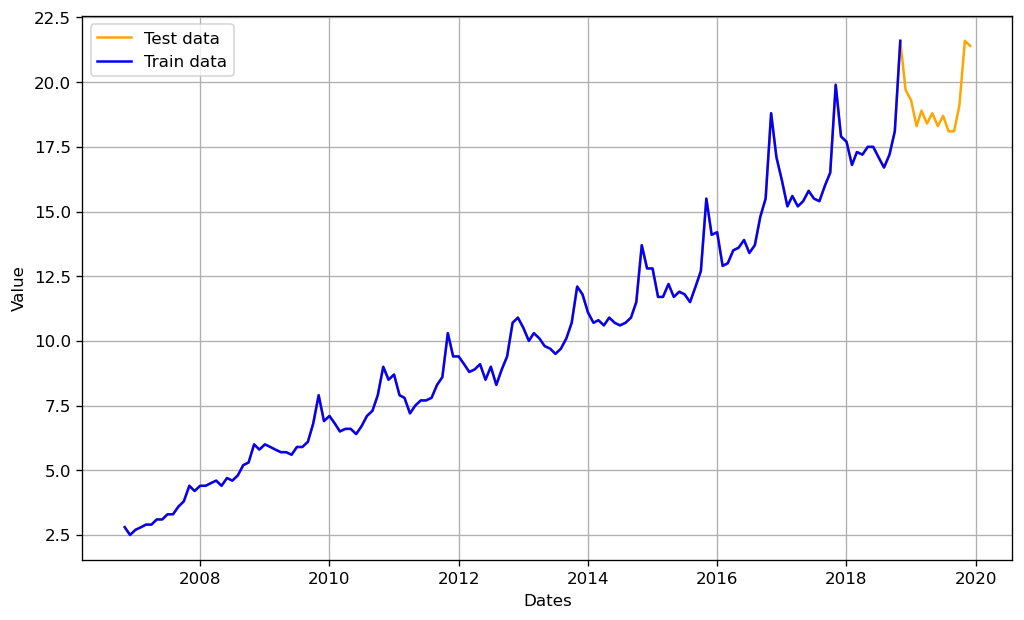

In [208]:
#split data into train and training set
df_test, df_train
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Value')
plt.plot(data_2019, 'orange', label='Test data')
plt.plot(df_train, 'blue', label='Train data')
plt.legend()

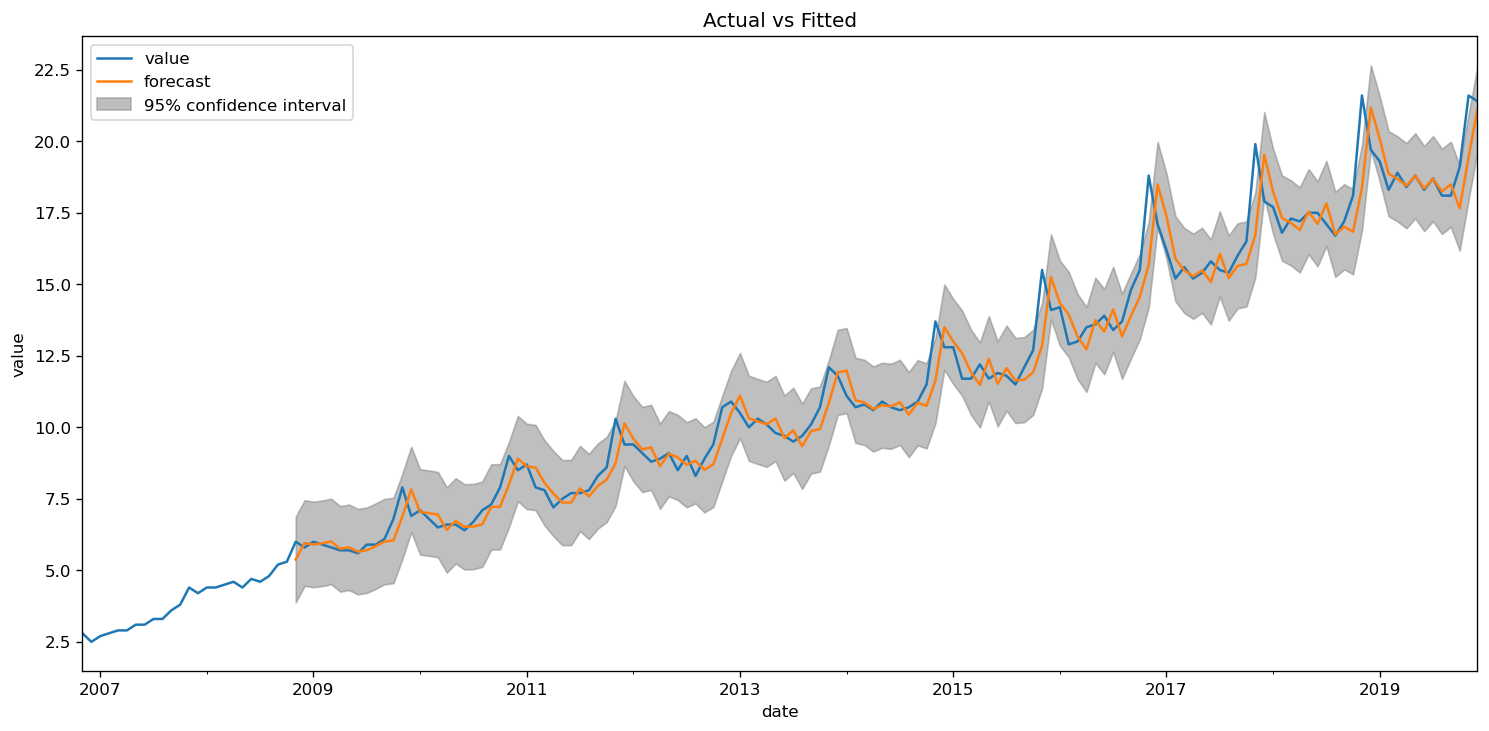

In [209]:
# Actual vs Fitted
res = ARIMA(data_2019, order=(2,0,1)).fit()
fig, ax = plt.subplots()
ax = data_2019.loc['2006-11-01':].plot(ax=ax)
plot_predict(res, '2008-11-01', '2019-12-01', ax=ax)
ax.set_ylabel('value')
ax.set_title('Actual vs Fitted')
plt.show()

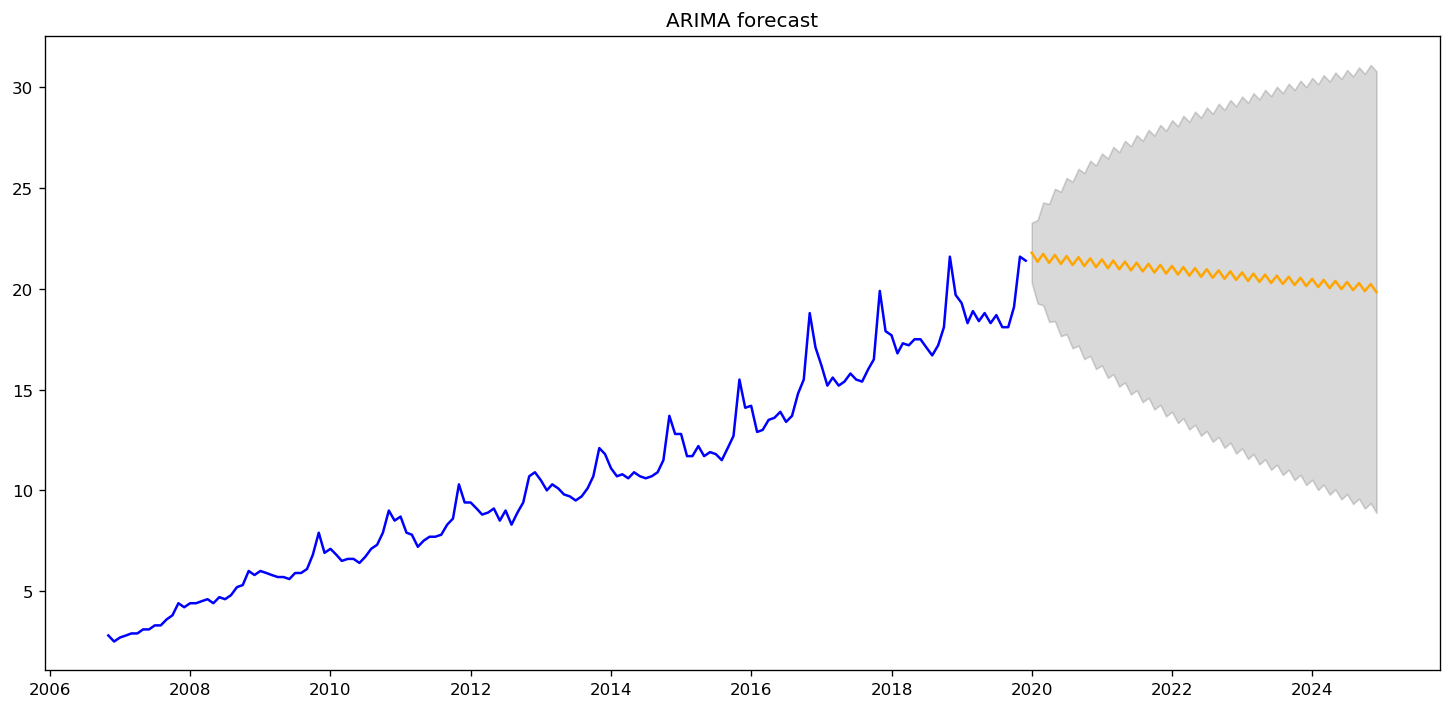

In [210]:
def forecast(ARIMA_model, periods=60):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data_2019.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(data_2019["value"], color='blue')
    plt.plot(fitted_series, color='orange')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA forecast")
    plt.show()

forecast(ARIMA_model)

In [211]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

In [212]:
SARIMA_model=auto_arima(data_2019['value'],seasonal=True,m=12)

In [213]:
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  158
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -59.935
Date:                            Fri, 06 Jan 2023   AIC                            125.869
Time:                                    03:10:13   BIC                            134.799
Sample:                                11-01-2006   HQIC                           129.498
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5196      0.059     -8.866      0.000      -0.634      -0.405
ma.S.L12      -0.2950      0.081   

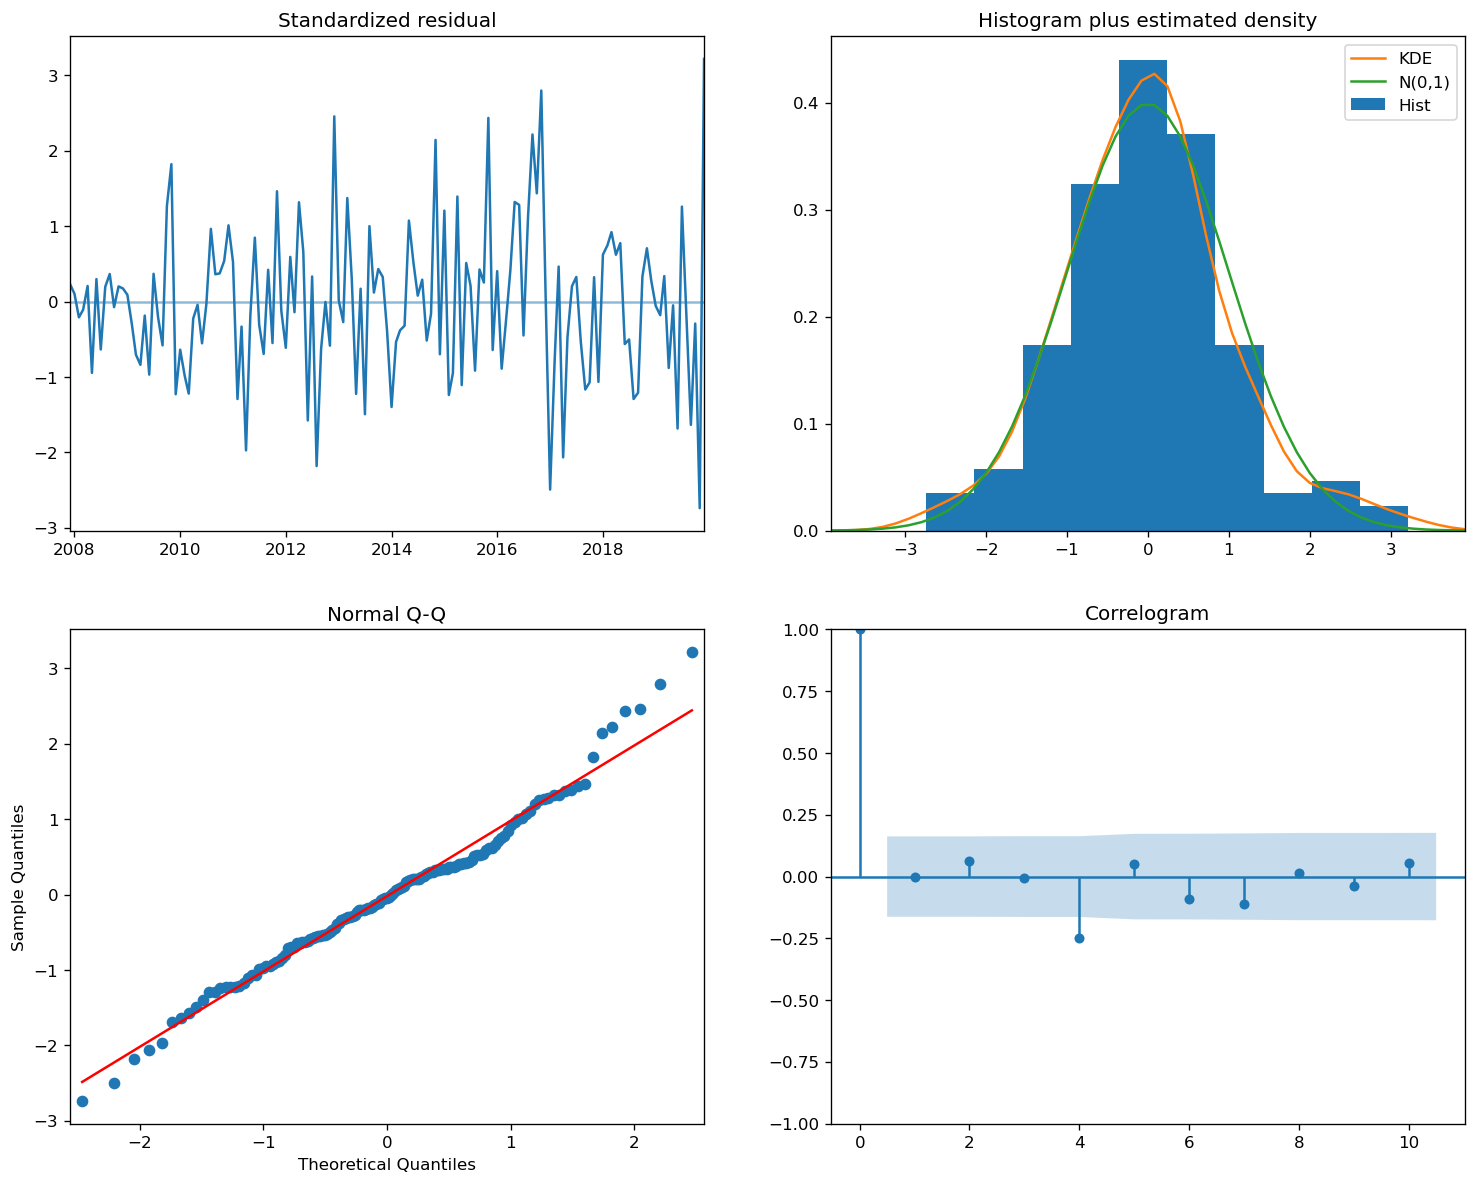

In [214]:

SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

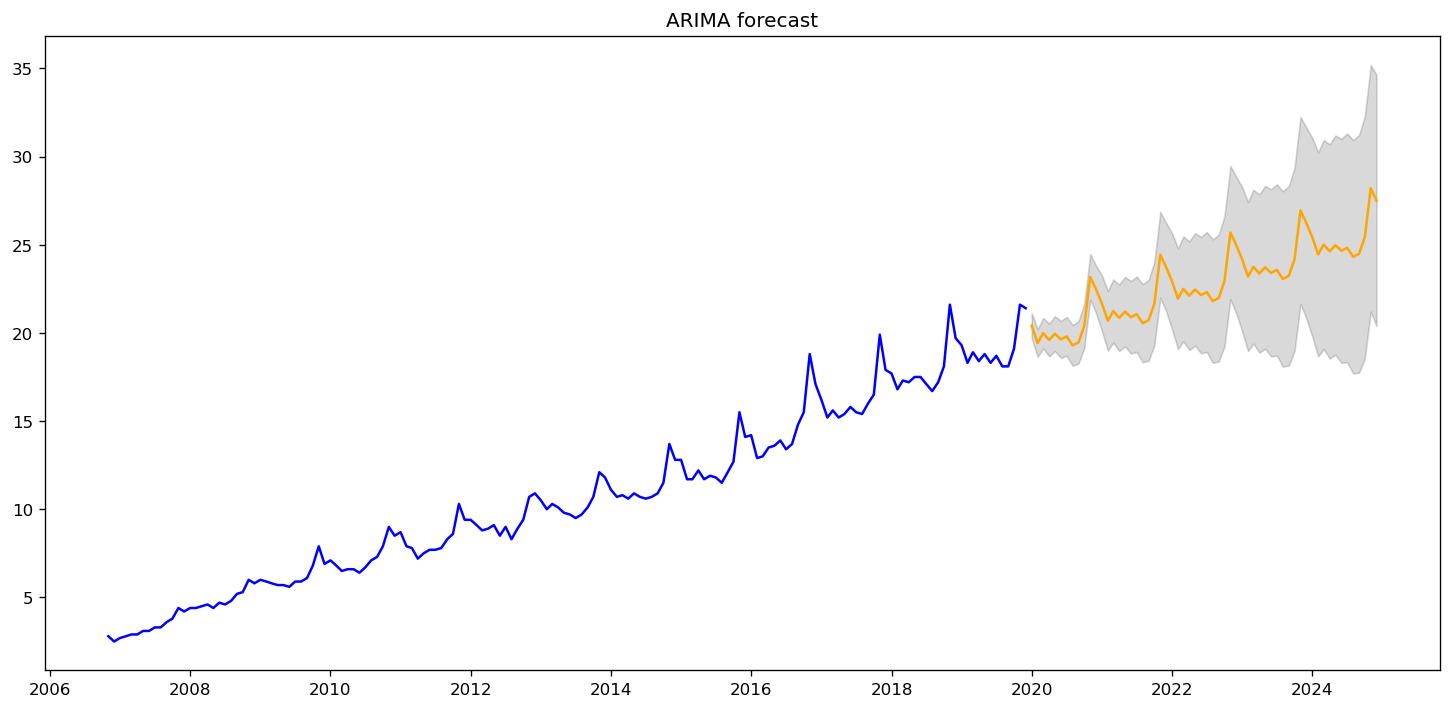

In [215]:
forecast(SARIMA_model)
#plt.title("ARIMA forecast with seasonality")


In [216]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [217]:
model = SARIMAX(df_train['value'],order=(0, 1, 1),seasonal_order=(0, 1, 1, 12))

In [218]:
results=model.fit()
results.summary()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32724D-01    |proj g|=  3.57669D-01

At iterate    5    f=  3.26666D-01    |proj g|=  1.60580D-03

At iterate   10    f=  3.26663D-01    |proj g|=  2.40589D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   2.406D-06   3.267D-01
  F =  0.32666314191545592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  145
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -47.366
Date:                            Fri, 06 Jan 2023   AIC                            100.732
Time:                                    03:10:30   BIC                            109.381
Sample:                                11-01-2006   HQIC                           104.247
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4458      0.084     -5.286      0.000      -0.611      -0.280
ma.S.L12      -0.2961      0.083   

In [219]:
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions = results.predict(start=start,end=end,dynamics=False,type='level')

In [221]:
predictions

2018-12-01    19.612005
2019-01-01    19.285427
2019-02-01    18.339930
2019-03-01    18.782275
2019-04-01    18.667072
2019-05-01    18.918242
2019-06-01    19.022272
2019-07-01    18.644891
2019-08-01    18.356080
2019-09-01    18.914024
2019-10-01    19.710434
2019-11-01    23.152620
2019-12-01    21.200505
Freq: MS, Name: predicted_mean, dtype: float64

In [222]:
for i in range(len(predictions)):
    print(f"predicted=={predictions[i]:<11.10},expected={df_test['value'][i]}")

predicted==19.61200537,expected=19.7
predicted==19.28542714,expected=19.3
predicted==18.33992961,expected=18.3
predicted==18.78227495,expected=18.9
predicted==18.66707203,expected=18.4
predicted==18.9182423 ,expected=18.8
predicted==19.02227229,expected=18.3
predicted==18.64489141,expected=18.7
predicted==18.35607951,expected=18.1
predicted==18.91402381,expected=18.1
predicted==19.71043392,expected=19.1
predicted==23.15262018,expected=21.6
predicted==21.20050512,expected=21.4


[Text(0.5, 0, ''), Text(0, 0.5, 'value')]

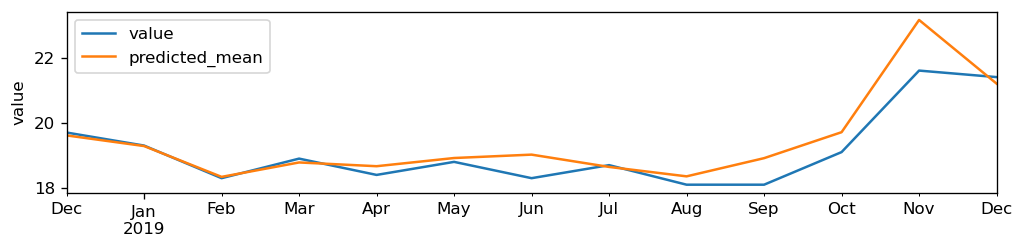

In [223]:
title = '% of online sales'
ylabel= 'value'
xlabel=''
ax = df_test['value'].plot(legend=True,figsize=(10,2))
predictions.plot(legend=True)
ax.autoscale(axis='X', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [80]:
from sklearn.metrics import mean_squared_error

In [224]:
mse=mean_squared_error(df_test['value'],predictions)
print(f'SARIMA(3,2,1) MES Error: {mse:12.11}')

SARIMA(3,2,1) MES Error: 0.32190004635


In [225]:
df_predicted=predictions

In [226]:
df_predicted

2018-12-01    19.612005
2019-01-01    19.285427
2019-02-01    18.339930
2019-03-01    18.782275
2019-04-01    18.667072
2019-05-01    18.918242
2019-06-01    19.022272
2019-07-01    18.644891
2019-08-01    18.356080
2019-09-01    18.914024
2019-10-01    19.710434
2019-11-01    23.152620
2019-12-01    21.200505
Freq: MS, Name: predicted_mean, dtype: float64

In [227]:
fcast_2019_onwards= results.predict(len(data_2019),len(data_2019)+276,typ='levels').rename('SARIMAX(0,1,1)Forecast').astype(np.int64)

In [228]:
fcast_2019_onwards

2020-01-01    20
2020-02-01    19
2020-03-01    20
2020-04-01    20
2020-05-01    20
              ..
2042-09-01    55
2042-10-01    56
2042-11-01    59
2042-12-01    57
2043-01-01    57
Freq: MS, Name: SARIMAX(0,1,1)Forecast, Length: 277, dtype: int64

In [229]:
fcast_2019_onwards.to_csv("forecast from 2019-2043.csv")

In [ ]:
#covid

In [230]:
data_2022=df

In [231]:
data_2022

value
date             
2006-11-01    2.8
2006-12-01    2.5
2007-01-01    2.7
2007-02-01    2.8
2007-03-01    2.9
...           ...
2022-07-01   25.1
2022-08-01   24.4
2022-09-01   25.4
2022-10-01   26.1
2022-11-01   30.2

[193 rows x 1 columns]

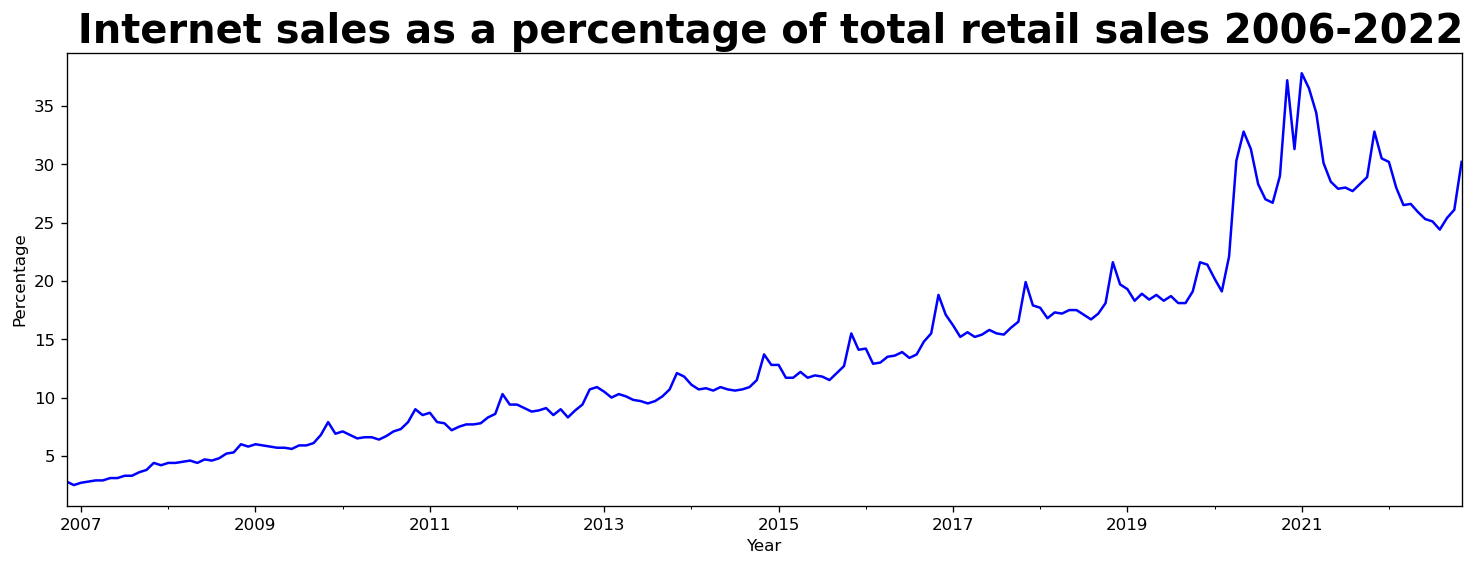

In [232]:
ax=data_2022['value'].plot(figsize=(15,5),color="blue")
plt.title(' Internet sales as a percentage of total retail sales 2006-2022' , fontweight="bold", size=24, color='black')
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')


plt.show()

In [233]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data_2022.value.dropna(),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:' ,result[4])

ADF Statistic: -0.707783
p-value: 0.844723
Critical Values: {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}


In [234]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


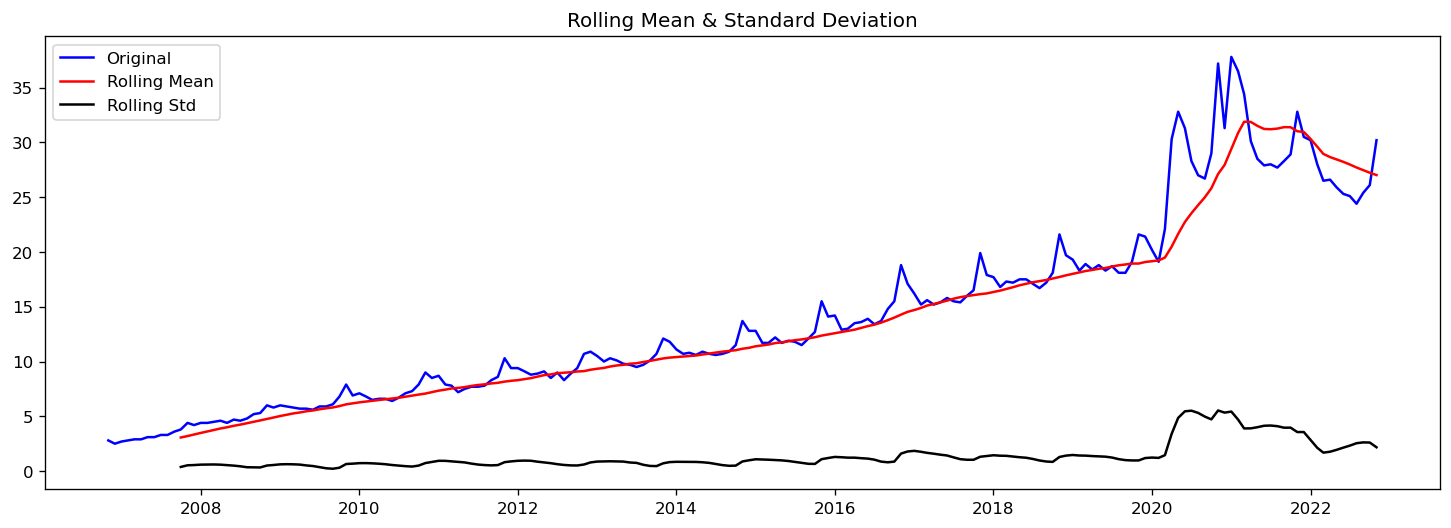

In [235]:
test_stationarity(data_2022['value'])

<Figure size 1800x840 with 0 Axes>

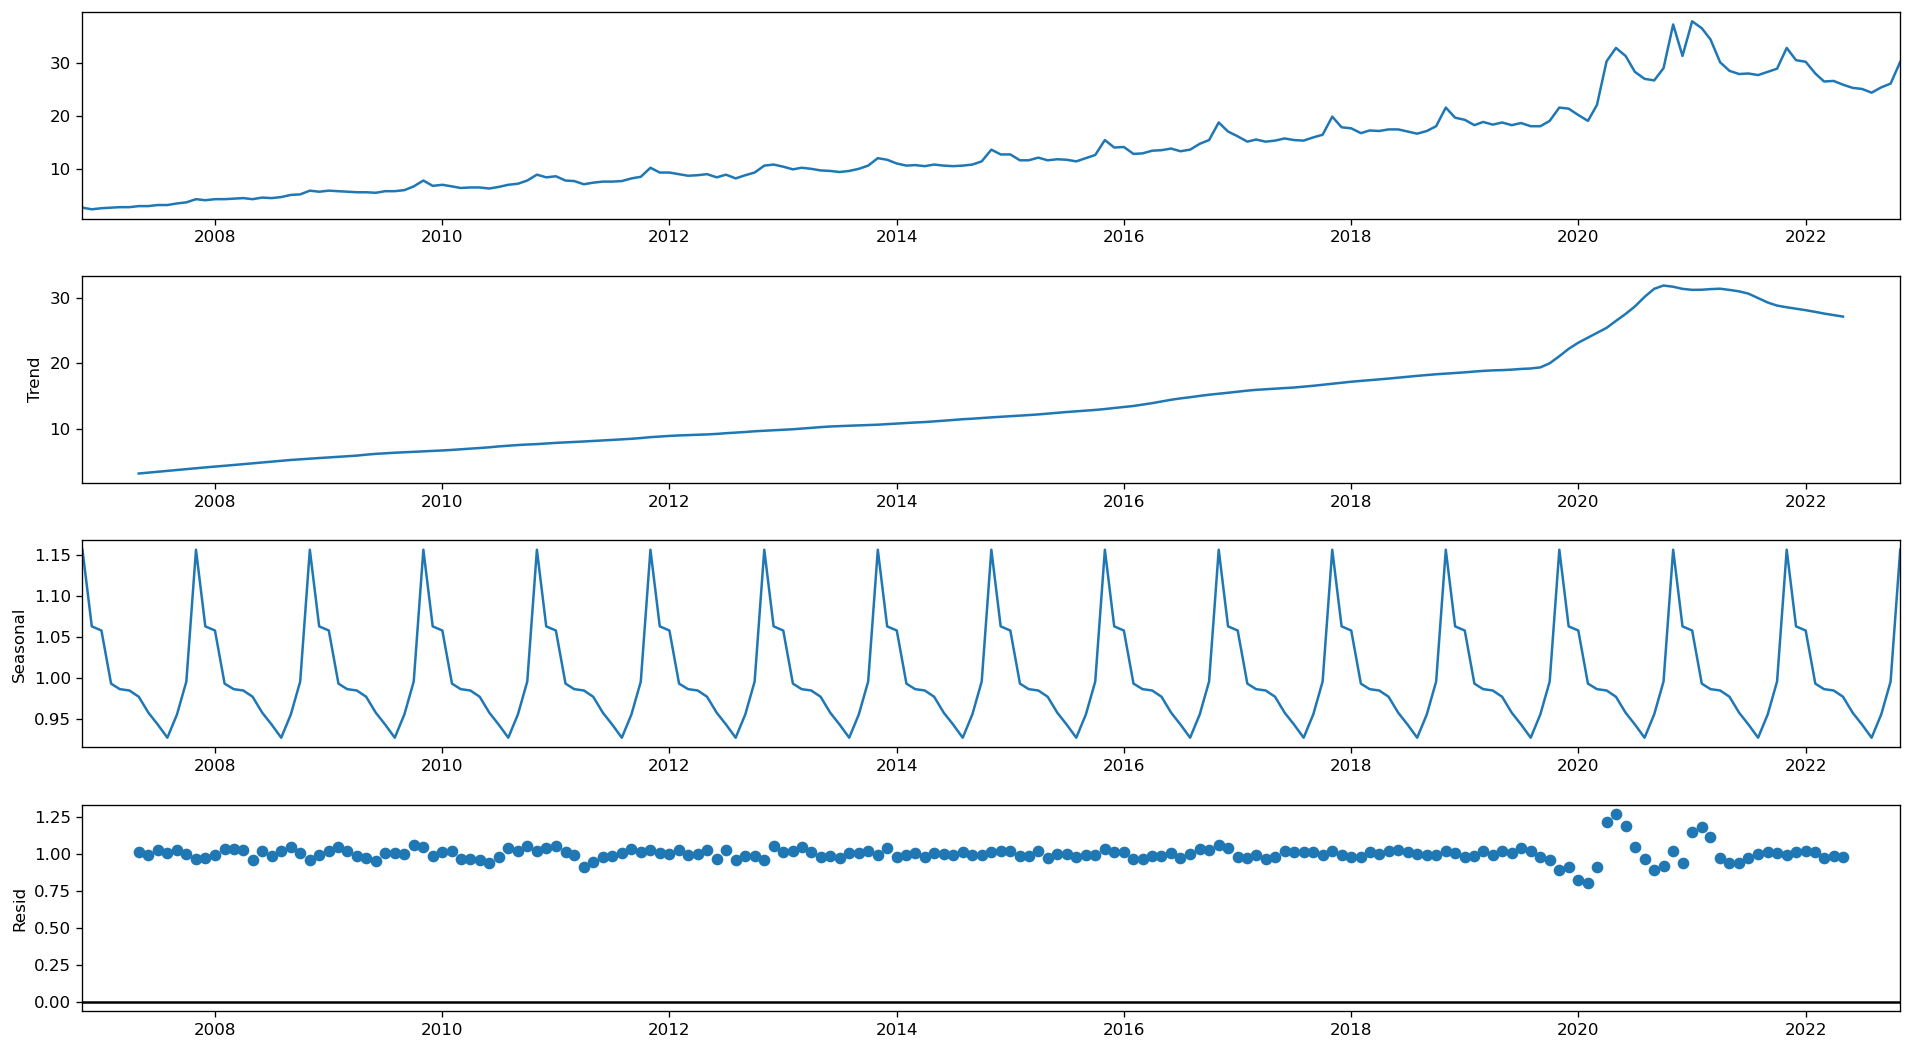

In [236]:

    #To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(data_2022, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)



In [237]:
SARIMA_model_1=auto_arima(data_2022['value'],seasonal=True,m=12)

In [238]:
print(SARIMA_model_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  193
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -301.233
Date:                            Fri, 06 Jan 2023   AIC                            622.466
Time:                                    03:17:40   BIC                            655.041
Sample:                                11-01-2006   HQIC                           635.659
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6370      0.083     19.738      0.000       1.474       1.799
ar.L2         -0.9919      0.078   

In [240]:
n1=len(data_2022)

n1


193

In [241]:
start_ind=n1-13
start_ind

180

In [244]:
df_training = data_2022.iloc[:start_ind] 

In [245]:
df_training

value
date             
2006-11-01    2.8
2006-12-01    2.5
2007-01-01    2.7
2007-02-01    2.8
2007-03-01    2.9
...           ...
2021-06-01   27.9
2021-07-01   28.0
2021-08-01   27.7
2021-09-01   28.3
2021-10-01   28.9

[180 rows x 1 columns]

In [246]:
df_testing= data_2022.iloc[start_ind:]

In [247]:
df_testing

value
date             
2021-11-01   32.8
2021-12-01   30.5
2022-01-01   30.2
2022-02-01   28.0
2022-03-01   26.5
2022-04-01   26.6
2022-05-01   25.9
2022-06-01   25.3
2022-07-01   25.1
2022-08-01   24.4
2022-09-01   25.4
2022-10-01   26.1
2022-11-01   30.2

In [248]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [249]:
model = SARIMAX(df_training['value'],order=(3, 2, 1),seasonal_order=(2,0,2,12))


In [250]:
results=model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86044D+00    |proj g|=  1.64022D+00

At iterate    5    f=  1.68075D+00    |proj g|=  5.34184D-02


 This problem is unconstrained.



At iterate   10    f=  1.60700D+00    |proj g|=  5.98619D-02

At iterate   15    f=  1.59582D+00    |proj g|=  2.01042D-02

At iterate   20    f=  1.58576D+00    |proj g|=  5.34418D-03

At iterate   25    f=  1.58539D+00    |proj g|=  1.65765D-03

At iterate   30    f=  1.58516D+00    |proj g|=  3.92883D-03

At iterate   35    f=  1.58441D+00    |proj g|=  7.78246D-04

At iterate   40    f=  1.58430D+00    |proj g|=  2.26940D-03

At iterate   45    f=  1.58428D+00    |proj g|=  5.00565D-04

At iterate   50    f=  1.58428D+00    |proj g|=  3.15658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   value   No. Observations:                  180
Model:             SARIMAX(3, 2, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -285.171
Date:                                 Fri, 06 Jan 2023   AIC                            588.342
Time:                                         03:23:25   BIC                            616.978
Sample:                                     11-01-2006   HQIC                           599.955
                                          - 10-01-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0182      0.039      0.463      0.643      -0.059       0.095
ar.L2          0.0277      0.056      0.496      0.620      -0.082       0.137
ar.L3         -0.1585      0.067     -2.365      0.018      -0.290      -0.027
ma.L1         -0.9996      0.162     -6.155      0.000      -1.318      -0.681
ar.S.L12       0.9324      0.325      2.865      0.004       0.294       1.570
ar.S.L24      -0.0115      0.343     -0.033      0.973      -0.684       0.661
ma.S.L12      -1.1751      0.282     -4.164      0.000      -1.728      -0.622
ma.S.L24       0.6035      0.268      2.248      0.025       0.077       1.130
sigma2         1.2525      0.191      6.545      0.000       0.877       1.628
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              3212.85
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              34.78   Skew:                             3.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [251]:
len(df_training)

180

In [253]:
len(df_testing)

13

In [254]:
start=len(df_training)
end=len(df_training)+len(df_testing)-1
predict = results.predict(start=start,end=end,dynamics=False,type='level')

In [255]:
predict

2021-11-01    30.831266
2021-12-01    30.340462
2022-01-01    28.120152
2022-02-01    27.359287
2022-03-01    29.341285
2022-04-01    32.511685
2022-05-01    34.129116
2022-06-01    33.670780
2022-07-01    32.835320
2022-08-01    32.094605
2022-09-01    32.032989
2022-10-01    33.384798
2022-11-01    37.880803
Freq: MS, Name: predicted_mean, dtype: float64

In [257]:
for i in range(len(predict)):
    print(f"predicted=={predict[i]:<11.10},expected={df_testing['value'][i]}")

predicted==30.83126583,expected=32.8
predicted==30.34046198,expected=30.5
predicted==28.12015182,expected=30.2
predicted==27.35928699,expected=28.0
predicted==29.34128514,expected=26.5
predicted==32.51168506,expected=26.6
predicted==34.12911625,expected=25.9
predicted==33.67077954,expected=25.3
predicted==32.83532026,expected=25.1
predicted==32.09460534,expected=24.4
predicted==32.03298945,expected=25.4
predicted==33.3847975 ,expected=26.1
predicted==37.88080281,expected=30.2


In [256]:
df_predict=predict.astype(np.int64)

In [258]:
model= SARIMAX(data_2022['value'],order=(3,2,1),seasonal_order=(2,0,2,12))
result=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14467D+00    |proj g|=  4.10096D+00


 This problem is unconstrained.



At iterate    5    f=  1.74665D+00    |proj g|=  2.74026D-01

At iterate   10    f=  1.66518D+00    |proj g|=  2.28340D-02

At iterate   15    f=  1.63202D+00    |proj g|=  6.73163D-02

At iterate   20    f=  1.62127D+00    |proj g|=  3.17011D-02

At iterate   25    f=  1.60097D+00    |proj g|=  1.44511D-02

At iterate   30    f=  1.60023D+00    |proj g|=  2.03960D-03

At iterate   35    f=  1.60008D+00    |proj g|=  3.56083D-03

At iterate   40    f=  1.59884D+00    |proj g|=  1.12636D-02

At iterate   45    f=  1.59852D+00    |proj g|=  3.25777D-03

At iterate   50    f=  1.59848D+00    |proj g|=  3.75676D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [261]:
fcast= result.predict(len(data_2022),len(data_2022)+260,typ='levels').rename('SARIMAX(1,1,1)Forecast').astype(np.int64)

In [262]:
fcast

2022-12-01    27
2023-01-01    28
2023-02-01    27
2023-03-01    28
2023-04-01    30
              ..
2044-04-01    60
2044-05-01    60
2044-06-01    60
2044-07-01    60
2044-08-01    60
Freq: MS, Name: SARIMAX(1,1,1)Forecast, Length: 261, dtype: int64

In [263]:
fcast.to_csv("forecast values from 2022-2044.csv")

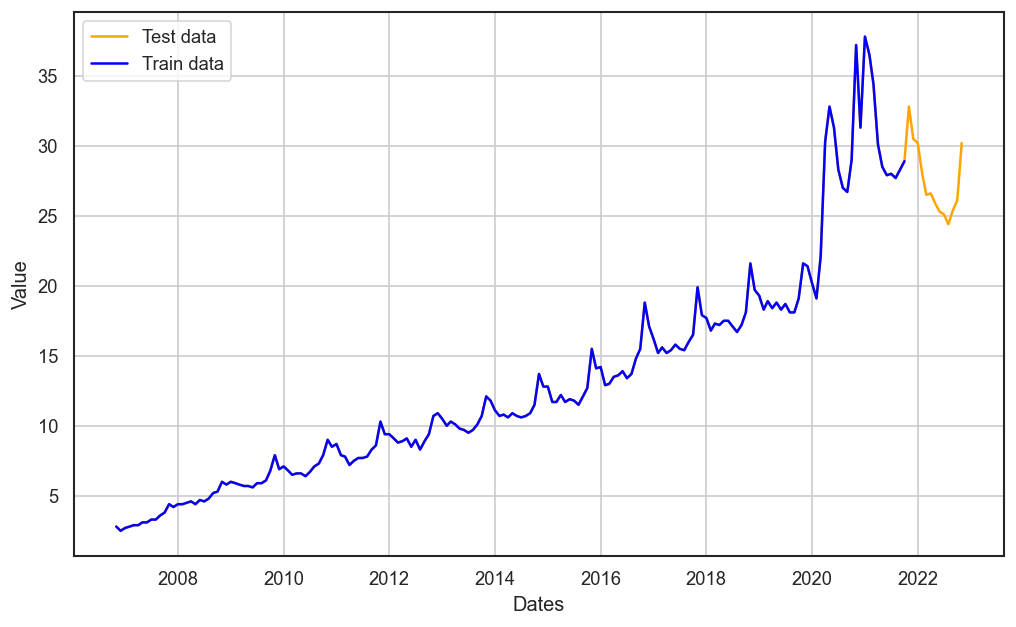

In [364]:
#split data into train and training set
df_testing, df_training
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Value')
plt.plot(data_2022, 'orange', label='Test data')
plt.plot(df_training, 'blue', label='Train data')
plt.legend()

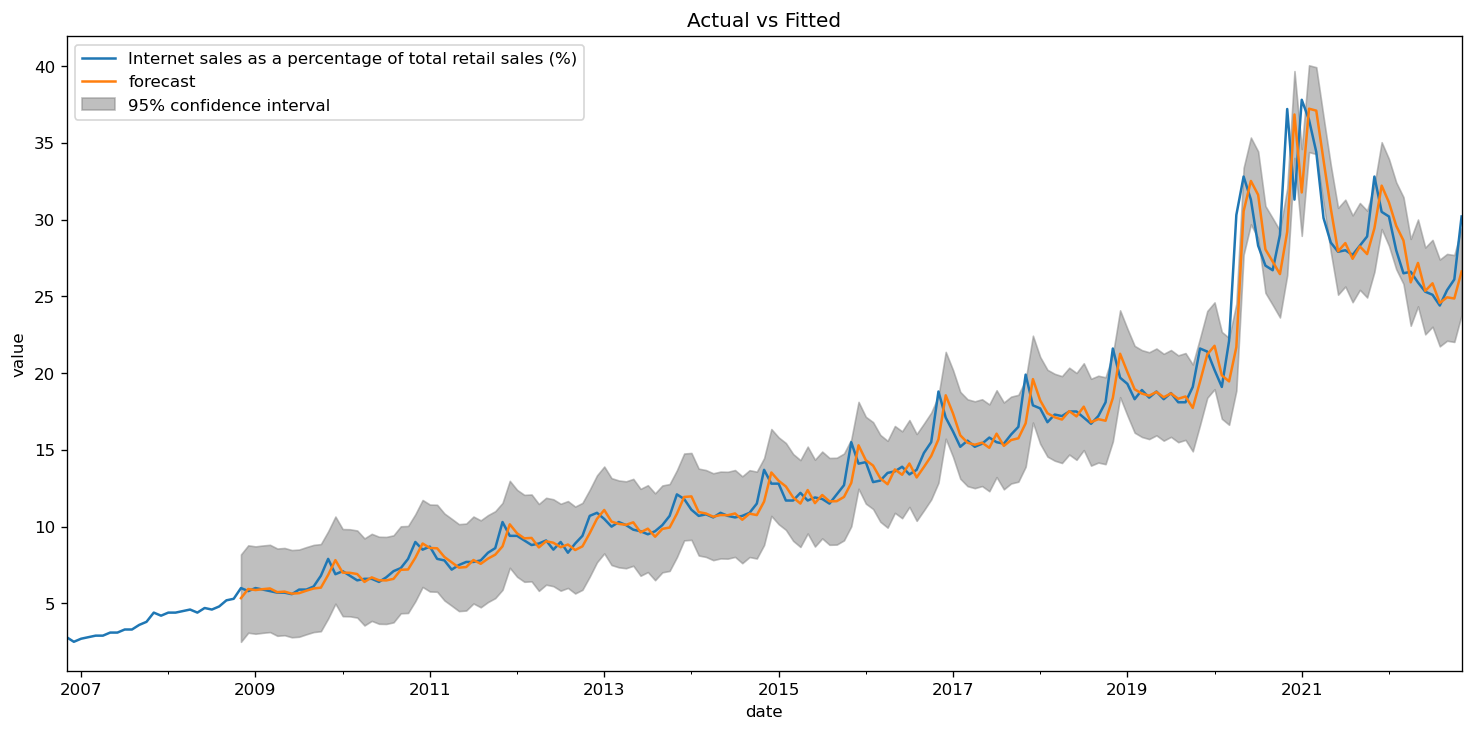

In [119]:
# Actual vs Fitted
res_1 = ARIMA(data_2022, order=(1,1,1)).fit()
fig, ax = plt.subplots()
ax = data_2022.loc['2006-11-01':].plot(ax=ax)
plot_predict(res_1, '2008-11-01', '2022-11-01', ax=ax)
ax.set_ylabel('value')
ax.set_title('Actual vs Fitted')
plt.show()

In [137]:
ARIMA_mod = pm.auto_arima(data_2022['value'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  193
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -343.330
Date:                Thu, 05 Jan 2023   AIC                            692.660
Time:                        19:11:16   BIC                            702.432
Sample:                    11-01-2006   HQIC                           696.618
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9977      0.015    -65.341      0.000      -1.028      -0.968
ma.L1          0.9782      0.036     26.916      0.000       0.907       1.049
sigma2         2.0811      0.089     23.498      0.0

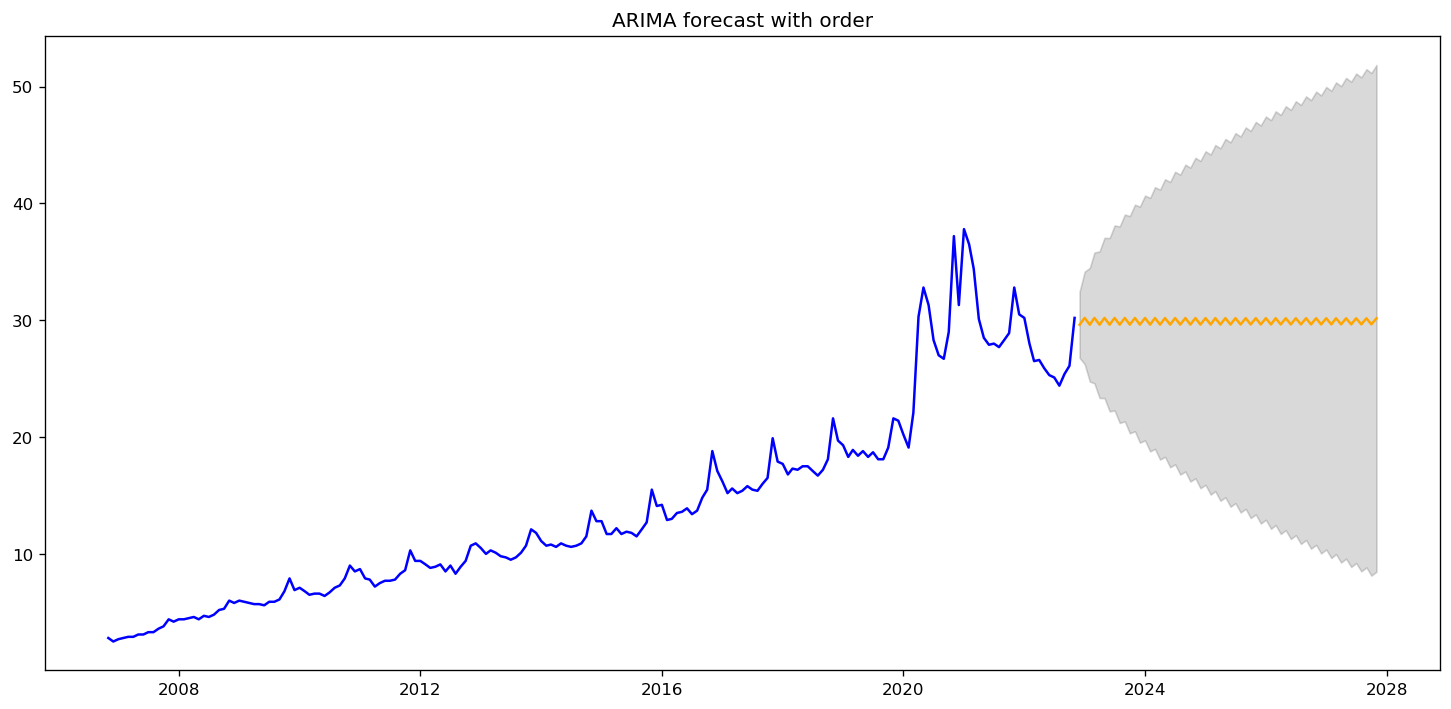

In [138]:
def forecast(ARIMA_mod, periods=60):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_mod.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data_2022.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(data_2022["value"], color='blue')
    plt.plot(fitted_series, color='orange')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA forecast with order")
    plt.show()

forecast(ARIMA_mod)

In [ ]:
SARIMA_model_1=auto_arima(data_2022['value'],seasonal=True,m=12)

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [123]:
model = SARIMAX(df_train_1['value'],order=(3, 1, 2),seasonal_order=(2, 0, 2, 12))

In [125]:
results=model.fit()
results.summary()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44636D+00    |proj g|=  1.39774D+00

At iterate    5    f=  1.58037D+00    |proj g|=  4.72891D-02

At iterate   10    f=  1.57131D+00    |proj g|=  1.56042D-02

At iterate   15    f=  1.56386D+00    |proj g|=  2.26648D-02

At iterate   20    f=  1.55530D+00    |proj g|=  3.84370D-02

At iterate   25    f=  1.55403D+00    |proj g|=  9.21574D-03

At iterate   30    f=  1.55216D+00    |proj g|=  1.34602D-02

At iterate   35    f=  1.55113D+00    |proj g|=  1.13139D-02

At iterate   40    f=  1.55075D+00    |proj g|=  1.38874D-02

At iterate   45    f=  1.55044D+00    |proj g|=  4.08672D-03

At iterate   50    f=  1.55040D+00    |proj g|=  3.22924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

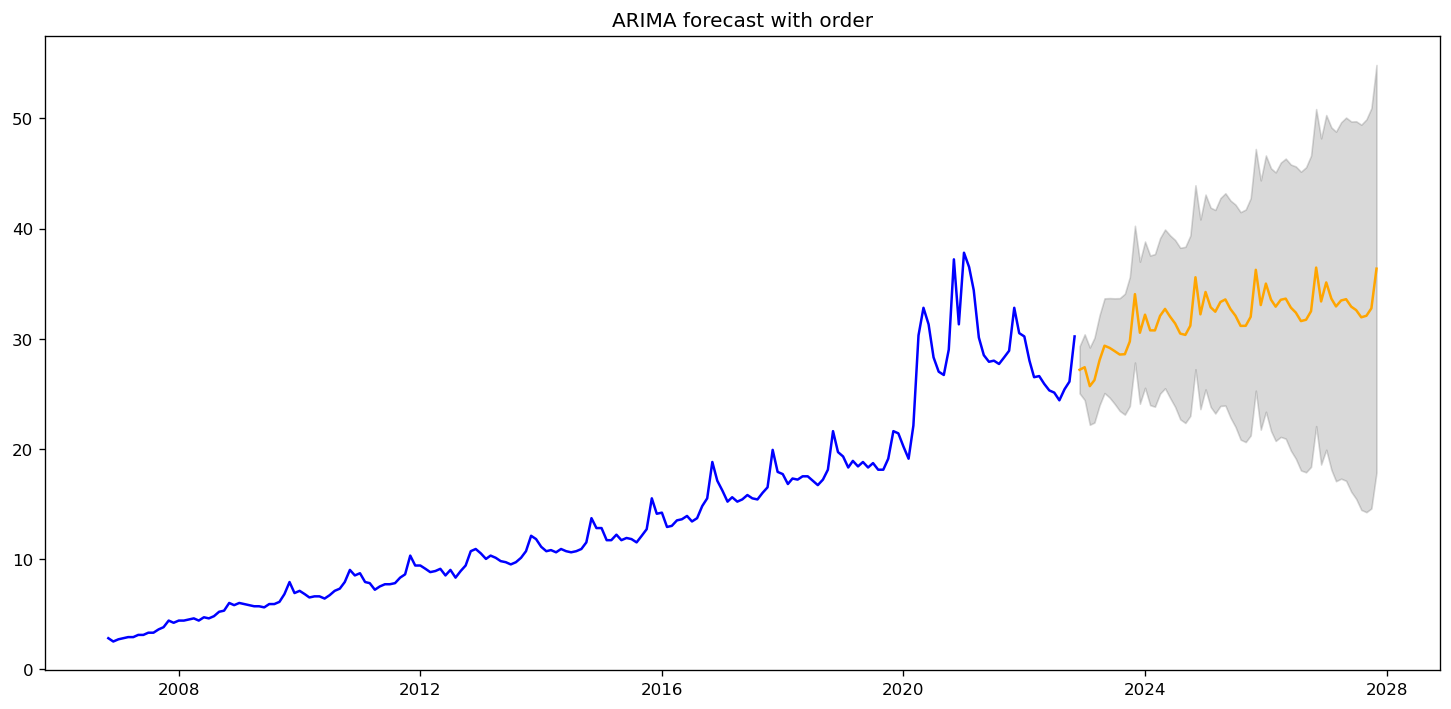

In [139]:
forecast(SARIMA_model_1)

In [365]:
mse=mean_squared_error(df_testing['value'],predictions_2022)
print(f'SARIMA(3,2,1) MES Error: {mse:12.11}')

SARIMA(3,2,1) MES Error: 28.216801163


#######EDA####

In [264]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [265]:
retail_ecom_sales_ = pd.read_excel('/Users/Apple/Downloads/dataDES/sales world wide.xlsx')

#df.info()

In [266]:
retail_ecom_sales_.head()

year  Retail e-commerce sales worldwide (in billion U.S. dollars)
0  2014                                               1336          
1  2015                                               1548          
2  2016                                               1845          
3  2017                                               2382          
4  2018                                               2982

Text(0.5, 1.0, 'Retail e-sales worldwide over time')

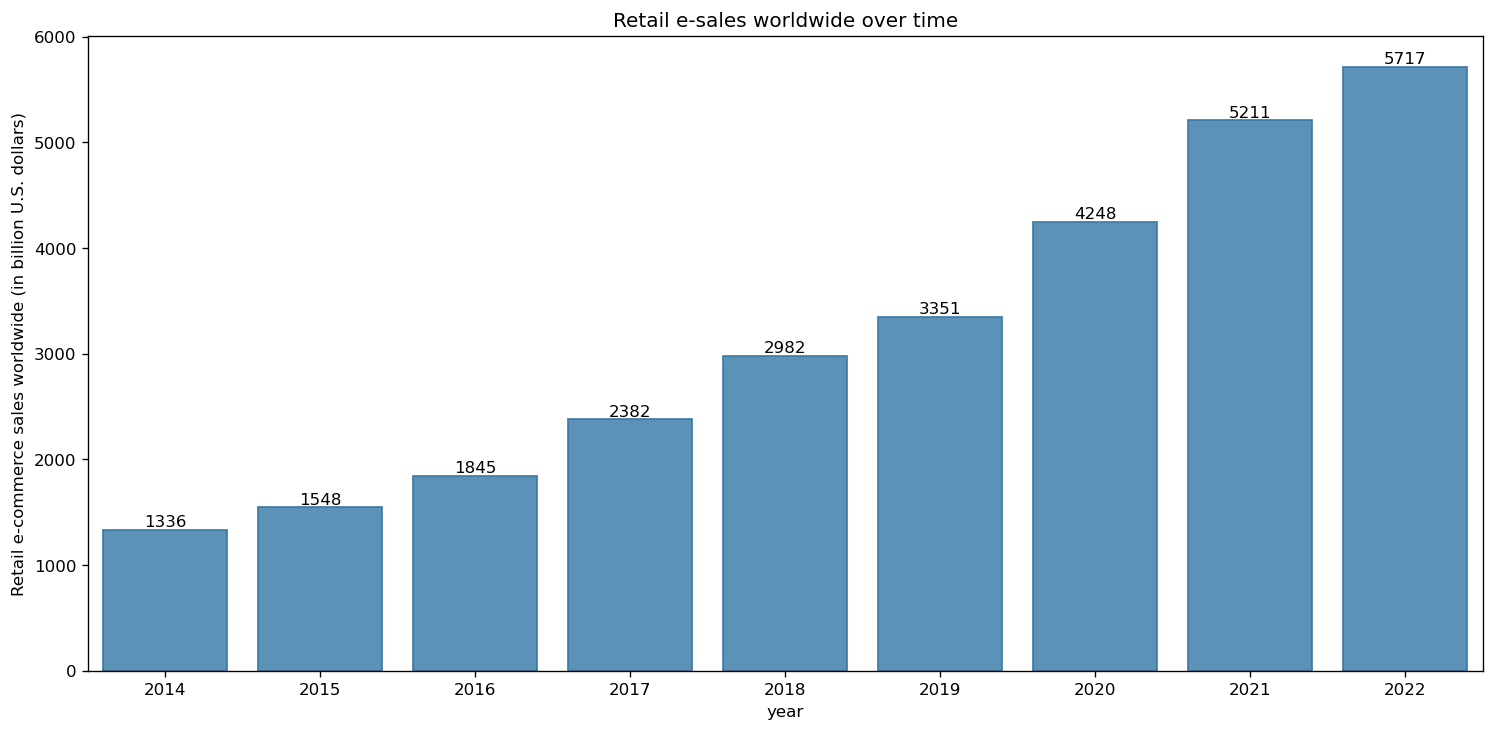

In [267]:
# show the relation years to general Unrated
plt.figure(figsize=(15,7))
ax=sns.barplot(data=retail_ecom_sales_ , x="year",y="Retail e-commerce sales worldwide (in billion U.S. dollars)",color='#4e95c7', edgecolor='#3a78a4')
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_title('Retail e-sales worldwide over time')    
#ax.bar_label(ax.containers[0])

In [268]:
sales_mode=pd.read_csv('/Users/Apple/Downloads/dataDES/sales by modes.csv')

In [269]:
sales_mode=sales_mode.dropna()

In [270]:
sales_mode

Year  Sales over a website  Sales over EDI  Total e-commerce sales
1   2009.0                 110.6           264.5                   375.1
2   2010.0                 118.5           300.5                   419.0
3   2011.0                 147.8           341.2                   489.0
4   2012.0                 172.9           300.7                   473.6
5   2013.0                 198.0           346.8                   544.7
6   2014.0                 227.4           286.1                   513.5
7   2015.0                 236.6           259.6                   496.2
8   2016.0                 247.9           260.9                   508.8
9   2017.0                 296.7           285.5                   582.2
10  2018.0                 354.4           323.4                   677.8
11  2019.0                 356.4           336.6                   693.0

Text(0.5, 1.0, 'e-commerce sales over different modes over time in the UK')

<Figure size 1800x840 with 0 Axes>

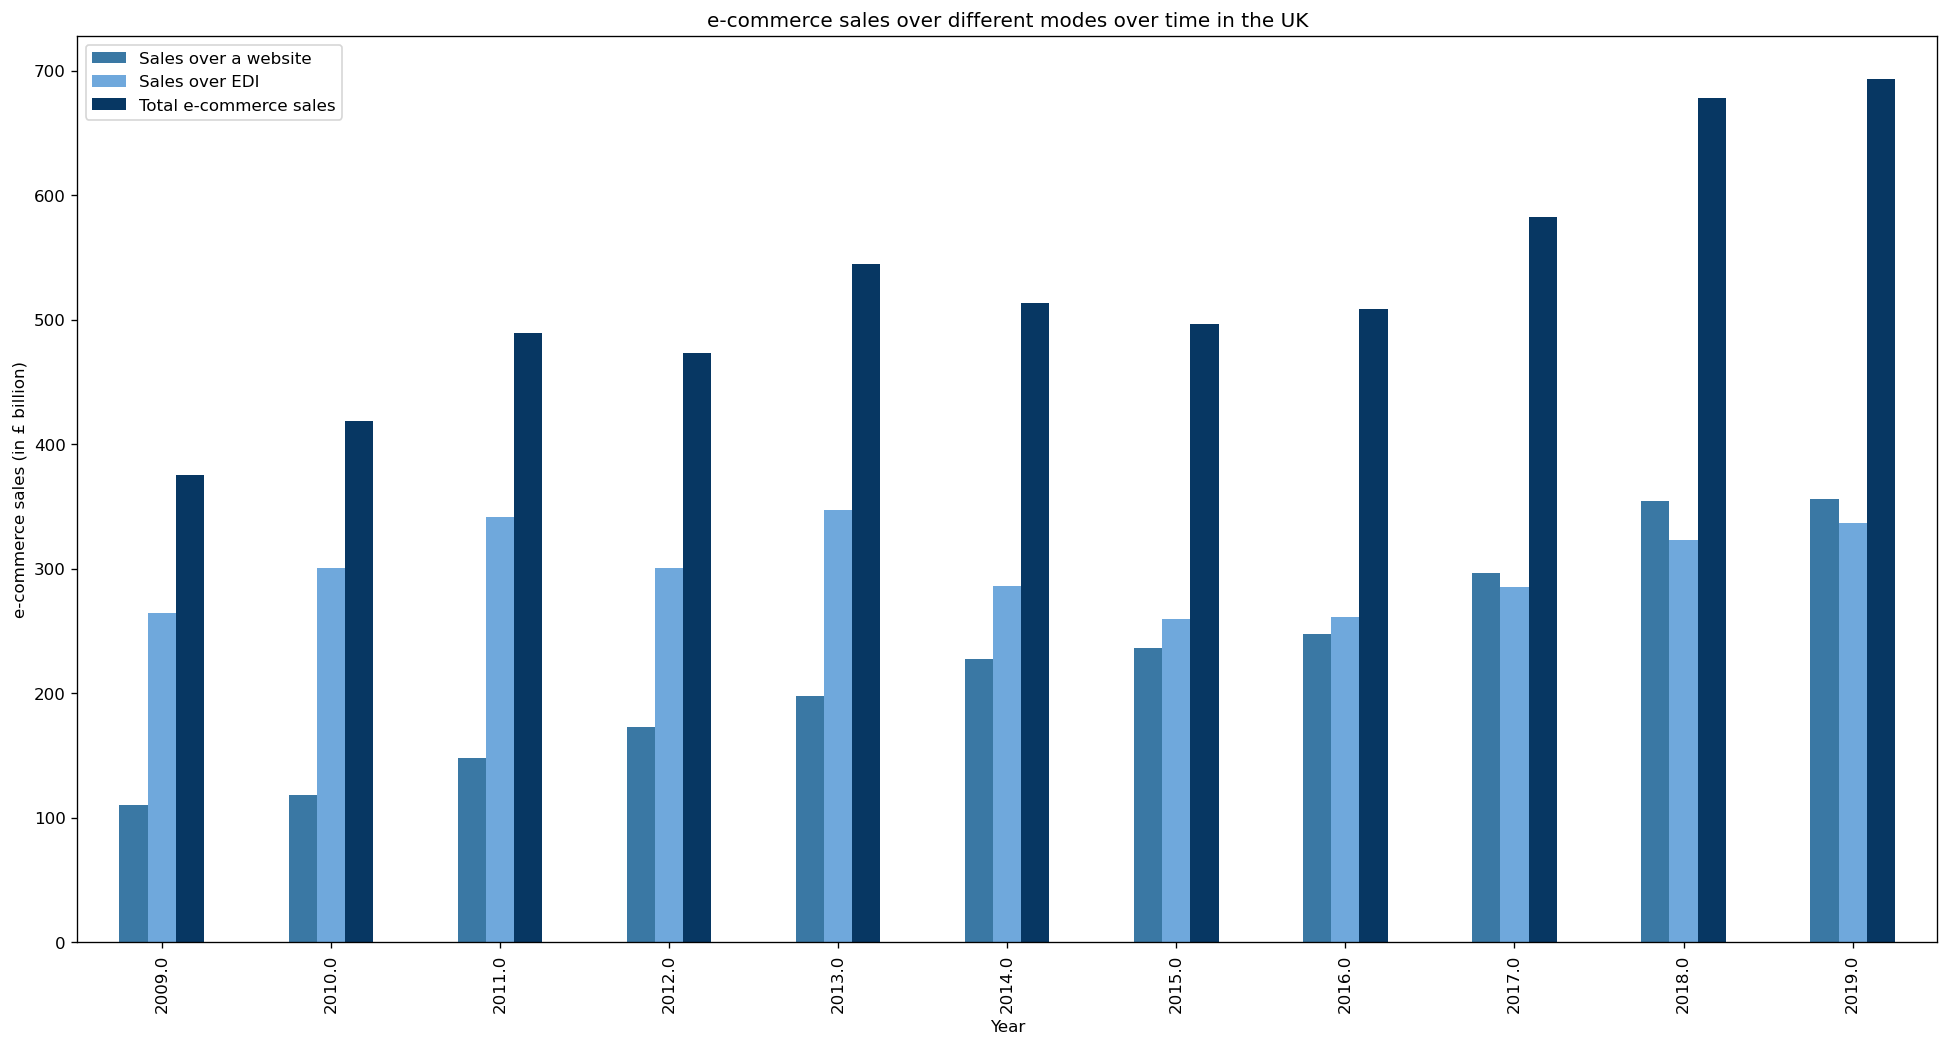

In [271]:
plt.figure(figsize=(15,7))
ax=sales_mode.plot.bar(x='Year',color=('#3a78a4','#6fa8dc','#073763'),figsize=(20, 10))
ax.set_ylabel( "e-commerce sales (in £ billion)")
ax.set_title('e-commerce sales over different modes over time in the UK')  
#color=('#d87eb3','#8dda6d','#3a78a4'

In [273]:
sales_size_company = pd.read_excel('/Users/Apple/Downloads/dataDES/test.xlsx')

In [276]:
sales_size_company=sales_size_company.fillna(0)
#sales_size_company1=sales_size_company.groupby('Year')
#sales_size_company1.head()

In [278]:
website_sale = sales_size_company[sales_size_company['Type'] == 'Website sales']

In [279]:
website_sale.head()



Type  Year  0 to 9 employees  10 to 49 employees  \
0  Website sales  2009               0.0                 7.8   
1  Website sales  2010               0.0                10.2   
2  Website sales  2011               0.0                12.4   
3  Website sales  2012               0.0                18.4   
4  Website sales  2013               0.0                18.7   

   50 to 249 employees  250 to 999 employees  1000 or more employees  \
0                 11.4                  31.5                    59.9   
1                 12.8                  31.2                    64.3   
2                 17.3                  33.8                    84.3   
3                 17.6                  40.1                    96.7   
4                 19.9                  49.5                   109.9   

   10 or more employees  All businesses  
0                 110.6             0.0  
1                 118.5             0.0  
2                 147.8             0.0  
3                 172.9             0.0  
4                 198.0             0.0

<function matplotlib.pyplot.legend(*args, **kwargs)>

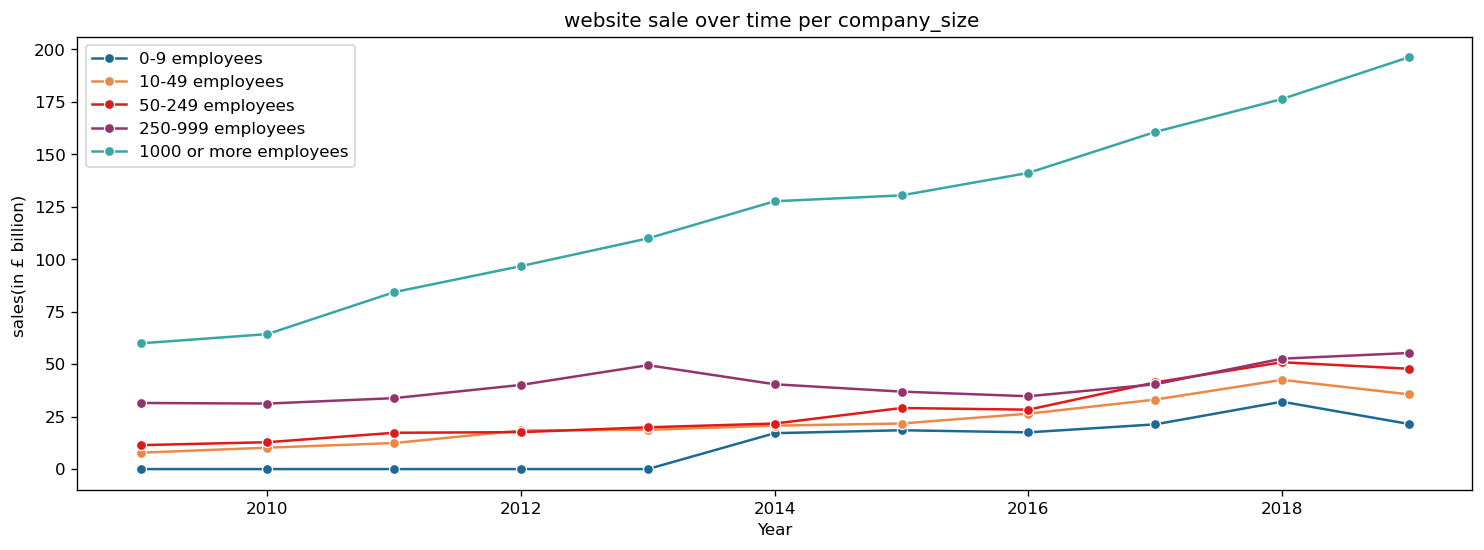

In [280]:
# show the Unemployment category
plt.figure(figsize=(15,5))

sns.lineplot(data=website_sale,x="Year",y="0 to 9 employees",label="0-9 employees",color='#1d6996',marker='o').set_ylabel( "sales(in £ billion) ")
sns.lineplot(data=website_sale,x="Year",y="10 to 49 employees",label="10-49 employees",color='#eb8947',marker='o')
sns.lineplot(data=website_sale,x="Year",y="50 to 249 employees",label="50-249 employees", color='#e11919',marker='o')
sns.lineplot(data=website_sale,x="Year",y='250 to 999 employees',label="250-999 employees",color='#94346e',marker='o')
sns.lineplot(data=website_sale,x="Year",y='1000 or more employees',label="1000 or more employees",color='#38a6a5', marker='o').set(title='website sale over time per company_size ')


#sns.lineplot(data=df1,x="Year",y='urate_abv50 ',label="unemprate above50")

plt.legend

In [281]:
EDI_sales = sales_size_company[sales_size_company['Type'] == 'EDI sales']

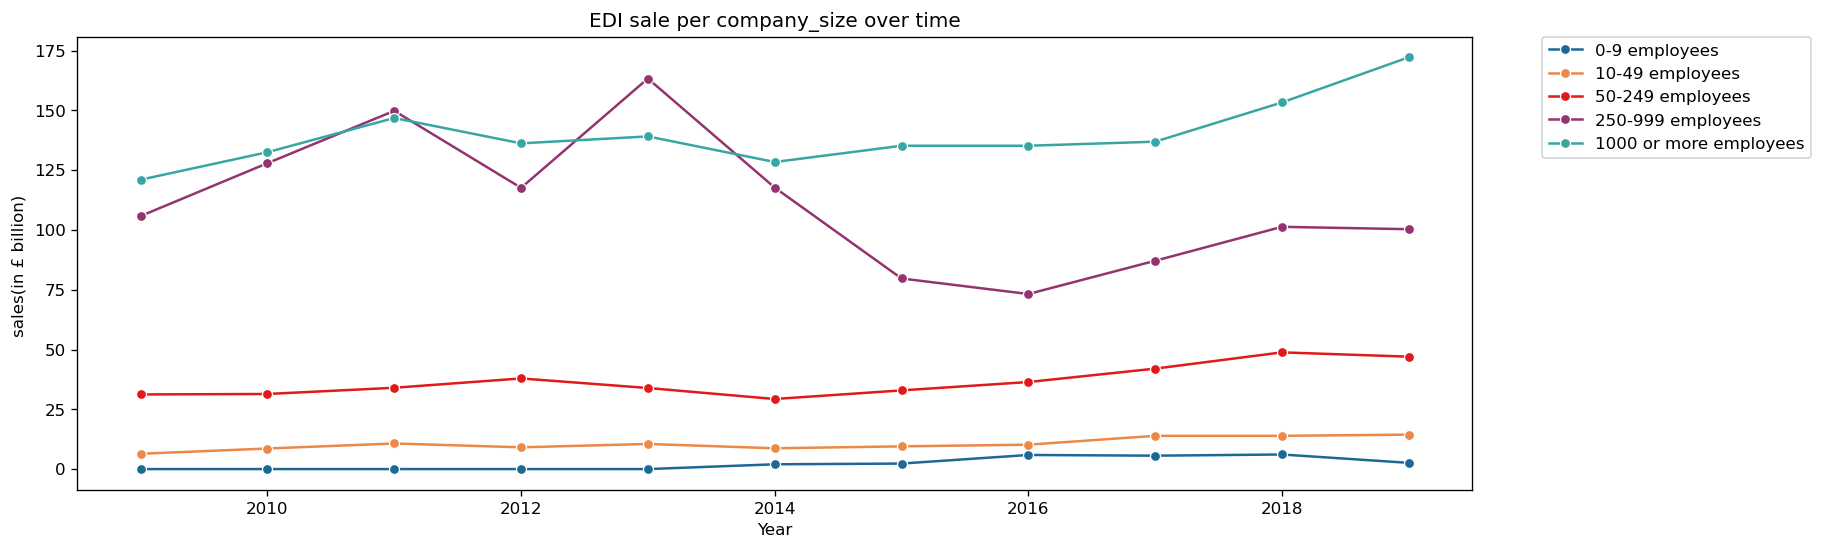

In [282]:
plt.figure(figsize=(15,5))

sns.lineplot(data=EDI_sales,x="Year",y="0 to 9 employees",label="0-9 employees",color='#1d6996',marker='o').set_ylabel( "sales(in £ billion) ")
sns.lineplot(data=EDI_sales,x="Year",y="10 to 49 employees",label="10-49 employees",color='#eb8947',marker='o')
sns.lineplot(data=EDI_sales,x="Year",y="50 to 249 employees",label="50-249 employees",color='#e11919',marker='o')
sns.lineplot(data=EDI_sales,x="Year",y='250 to 999 employees',label="250-999 employees",color='#94346e',marker='o')
sns.lineplot(data=EDI_sales,x="Year",y='1000 or more employees',label="1000 or more employees",color='#38a6a5', marker='o').set(title='EDI sale per company_size over time')


#sns.lineplot(data=df1,x="Year",y='urate_abv50 ',label="unemprate above50")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [283]:
Total_ecommerce_sales = sales_size_company[sales_size_company['Type'] == 'Total e-commerce sales']

In [284]:
Total_ecommerce_sales

Type  Year  0 to 9 employees  10 to 49 employees  \
22  Total e-commerce sales  2009               0.0                14.2   
23  Total e-commerce sales  2010               0.0                18.8   
24  Total e-commerce sales  2011               0.0                23.1   
25  Total e-commerce sales  2012               0.0                27.5   
26  Total e-commerce sales  2013               0.0                29.1   
27  Total e-commerce sales  2014              19.0                29.4   
28  Total e-commerce sales  2015              20.8                31.2   
29  Total e-commerce sales  2016              23.4                36.6   
30  Total e-commerce sales  2017              27.0                47.0   
31  Total e-commerce sales  2018              38.2                56.5   
32  Total e-commerce sales  2019              24.1                50.0   

    50 to 249 employees  250 to 999 employees  1000 or more employees  \
22                 42.6                 137.4                   180.9   
23                 44.3                 159.1                   196.9   
24                 51.3                 183.6                   231.1   
25                 55.5                 157.7                   232.9   
26                 53.8                 212.9                   249.0   
27                 51.0                 158.1                   256.0   
28                 62.0                 116.6                   265.6   
29                 64.7                 107.9                   276.3   
30                 83.3                 127.5                   297.5   
31                 99.7                 153.9                   329.6   
32                 94.8                 155.6                   368.5   

    10 or more employees  All businesses  
22                 375.1             0.0  
23                 419.0             0.0  
24                 489.0             0.0  
25                 473.6             0.0  
26                 544.7             0.0  
27                 494.5           513.5  
28                 475.4           496.2  
29                 485.4           508.8  
30                 555.2           582.2  
31                 639.7           677.8  
32                 668.9           693.0

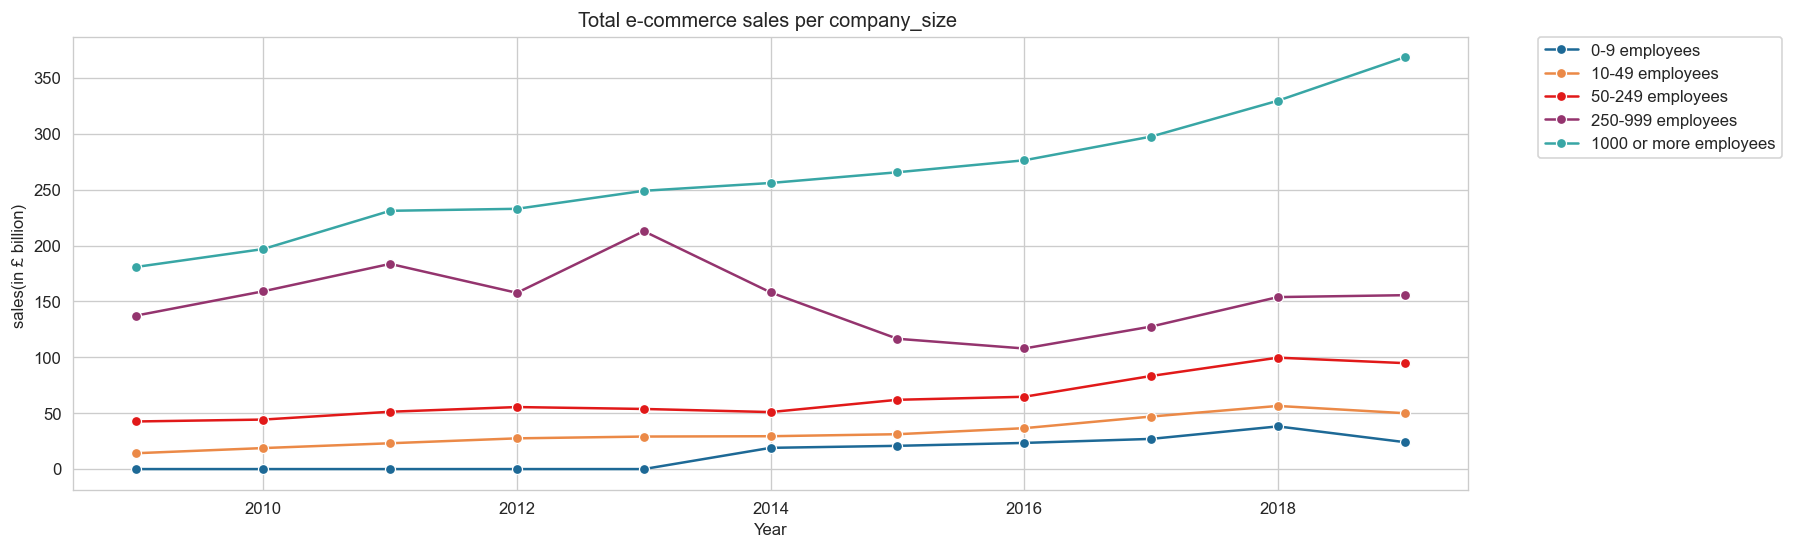

In [285]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.lineplot(data=Total_ecommerce_sales,x="Year",y="0 to 9 employees",label="0-9 employees",color='#1d6996',marker='o').set_ylabel( "sales(in £ billion) ")
sns.lineplot(data=Total_ecommerce_sales,x="Year",y="10 to 49 employees",label="10-49 employees",color='#eb8947',marker='o')
sns.lineplot(data=Total_ecommerce_sales,x="Year",y="50 to 249 employees",label="50-249 employees",color='#e11919',marker='o')
sns.lineplot(data=Total_ecommerce_sales,x="Year",y='250 to 999 employees',label="250-999 employees",color='#94346e',marker='o')
sns.lineplot(data=Total_ecommerce_sales,x="Year",y='1000 or more employees',label="1000 or more employees",color='#38a6a5', marker='o').set(title='Total e-commerce sales per company_size ')


#sns.lineplot(data=df1,x="Year",y='urate_abv50 ',label="unemprate above50")
# update legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [286]:
per_sec_sales = pd.read_excel('/Users/Apple/Downloads/dataDES/per_sec_sales19.xlsx')



In [287]:
per_sec_sales

Year  Accommodation and food services  Construction  \
0   2009                              5.3           3.4   
1   2010                              5.3           3.3   
2   2011                              5.8           4.2   
3   2012                              9.0           3.8   
4   2013                             10.4           4.4   
5   2014                             11.2           6.3   
6   2015                             10.9           8.8   
7   2016                             12.9           9.0   
8   2017                             14.7           8.4   
9   2018                             14.4          10.8   
10  2019                             17.9          13.2   

    Information and communication  Manufacturing  Other services  Retail  \
0                            24.0          116.9            14.0    13.6   
1                            29.8          125.2            19.1    14.7   
2                            37.8          150.9            26.7    21.1   
3                            42.6          139.2            24.1    23.1   
4                            42.3          149.2            25.8    26.3   
5                            31.7          157.7            29.0    31.3   
6                            32.0          155.2            35.4    34.5   
7                            32.8          163.1            40.2    39.4   
8                            42.3          170.1            44.3    49.8   
9                            57.1          185.0            45.4    57.7   
10                           60.5          188.1            41.0    60.4   

    Transport and storage  Wholesale  Utilities  
0                    40.0      144.7       13.3  
1                    39.0      167.5       15.1  
2                    44.0      183.5       15.2  
3                    41.8      173.9       16.2  
4                    44.9      228.1       13.2  
5                    49.0      179.6       17.8  
6                    54.5      145.0       19.8  
7                    57.4      141.8       12.3  
8                    64.8      171.1       16.8  
9                    74.6      219.1       13.8  
10                   78.4      214.7       19.0

Text(0.5, 1.0, 'sector wise sales over time')

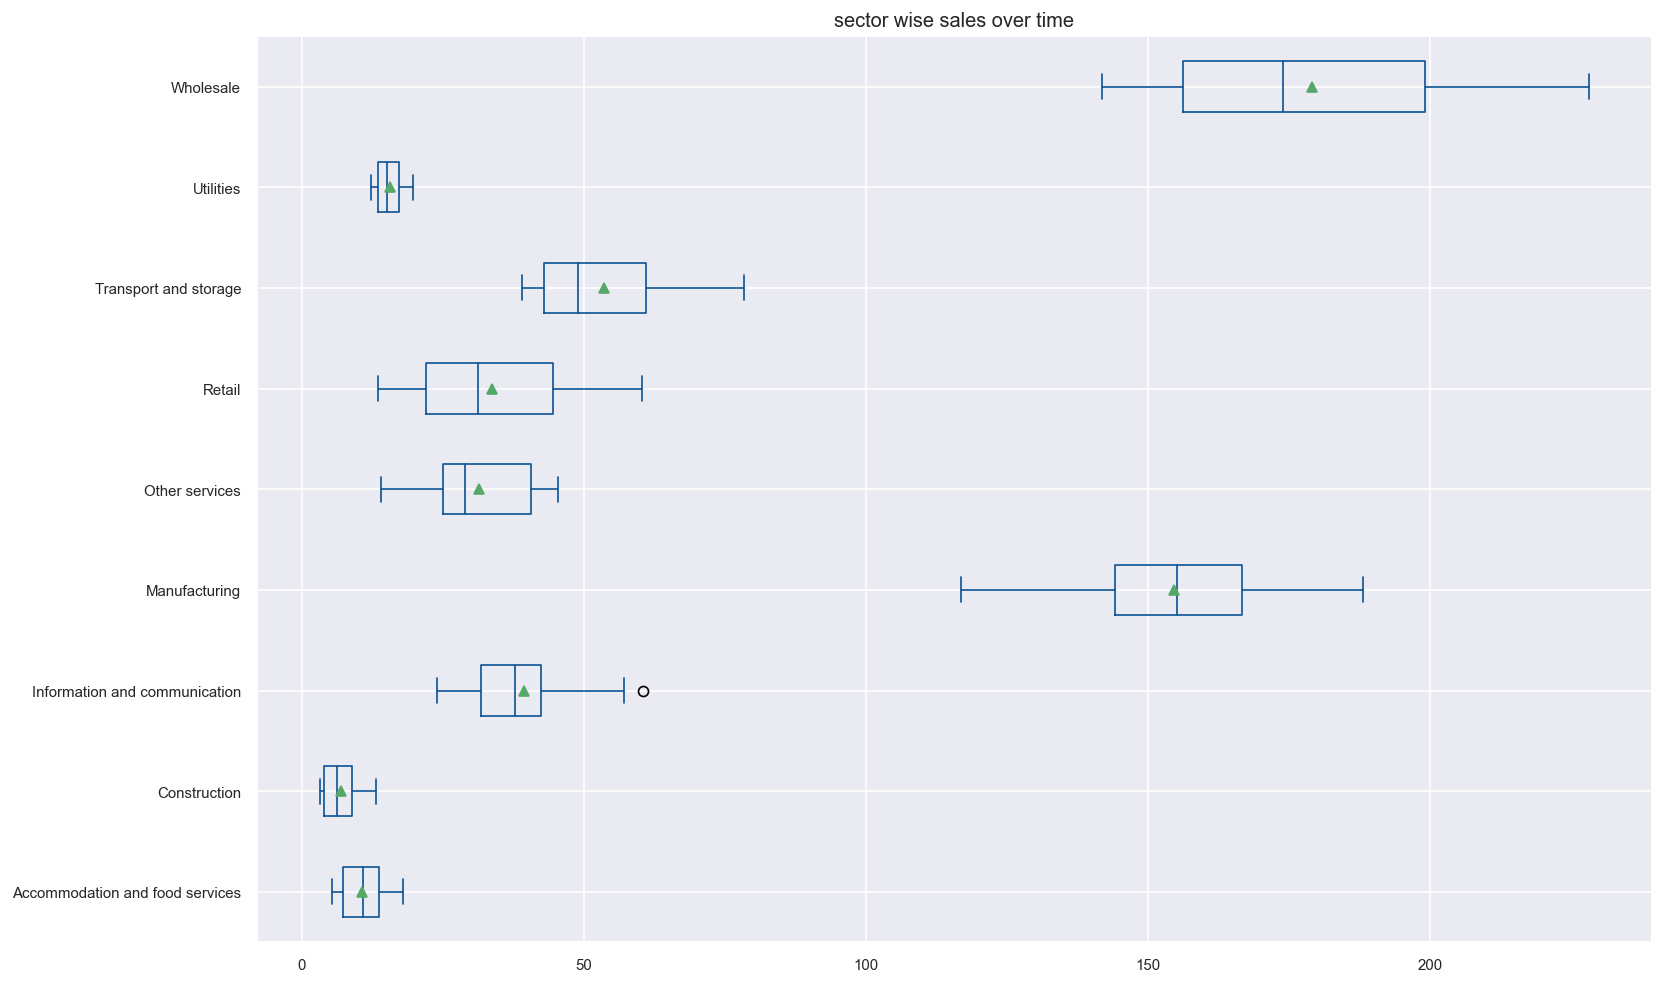

In [288]:
plt.figure(figsize=(15,10))


sns.set(style="dark")
b_plot = per_sec_sales.boxplot(showmeans=True,color='#0b5394',grid=True , fontsize=9,vert=0,column = ['Accommodation and food services', 'Construction', 'Information and communication','Manufacturing','Other services','Retail','Transport and storage','Utilities','Wholesale']) 
b_plot.plot(vert=True)
#colors = ['blue', 'green','red','#f1c232', 'purple','pink','#e69138','brown','#0b5394']


    
b_plot.set_title( 'sector wise sales over time')

In [289]:
dec=per_sec_sales.describe().T

In [290]:
dec

count         mean        std     min  \
Year                              11.0  2014.000000   3.316625  2009.0   
Accommodation and food services   11.0    10.709091   4.146916     5.3   
Construction                      11.0     6.872727   3.374638     3.3   
Information and communication     11.0    39.354545  11.291711    24.0   
Manufacturing                     11.0   154.600000  22.213825   116.9   
Other services                    11.0    31.363636  10.557203    14.0   
Retail                            11.0    33.809091  16.363829    13.6   
Transport and storage             11.0    53.490909  13.867116    39.0   
Wholesale                         11.0   179.000000  30.415325   141.8   
Utilities                         11.0    15.681818   2.477022    12.3   

                                     25%     50%      75%     max  
Year                             2011.50  2014.0  2016.50  2019.0  
Accommodation and food services     7.40    10.9    13.65    17.9  
Construction                        4.00     6.3     8.90    13.2  
Information and communication      31.85    37.8    42.45    60.5  
Manufacturing                     144.20   155.2   166.60   188.1  
Other services                     24.95    29.0    40.60    45.4  
Retail                             22.10    31.3    44.60    60.4  
Transport and storage              42.90    49.0    61.10    78.4  
Wholesale                         156.25   173.9   199.10   228.1  
Utilities                          13.55    15.2    17.30    19.8

In [ ]:
file_name = '/Users/Apple/Downloads/dataDES/d_table1.xlsx'
dec.to_excel(file_name)

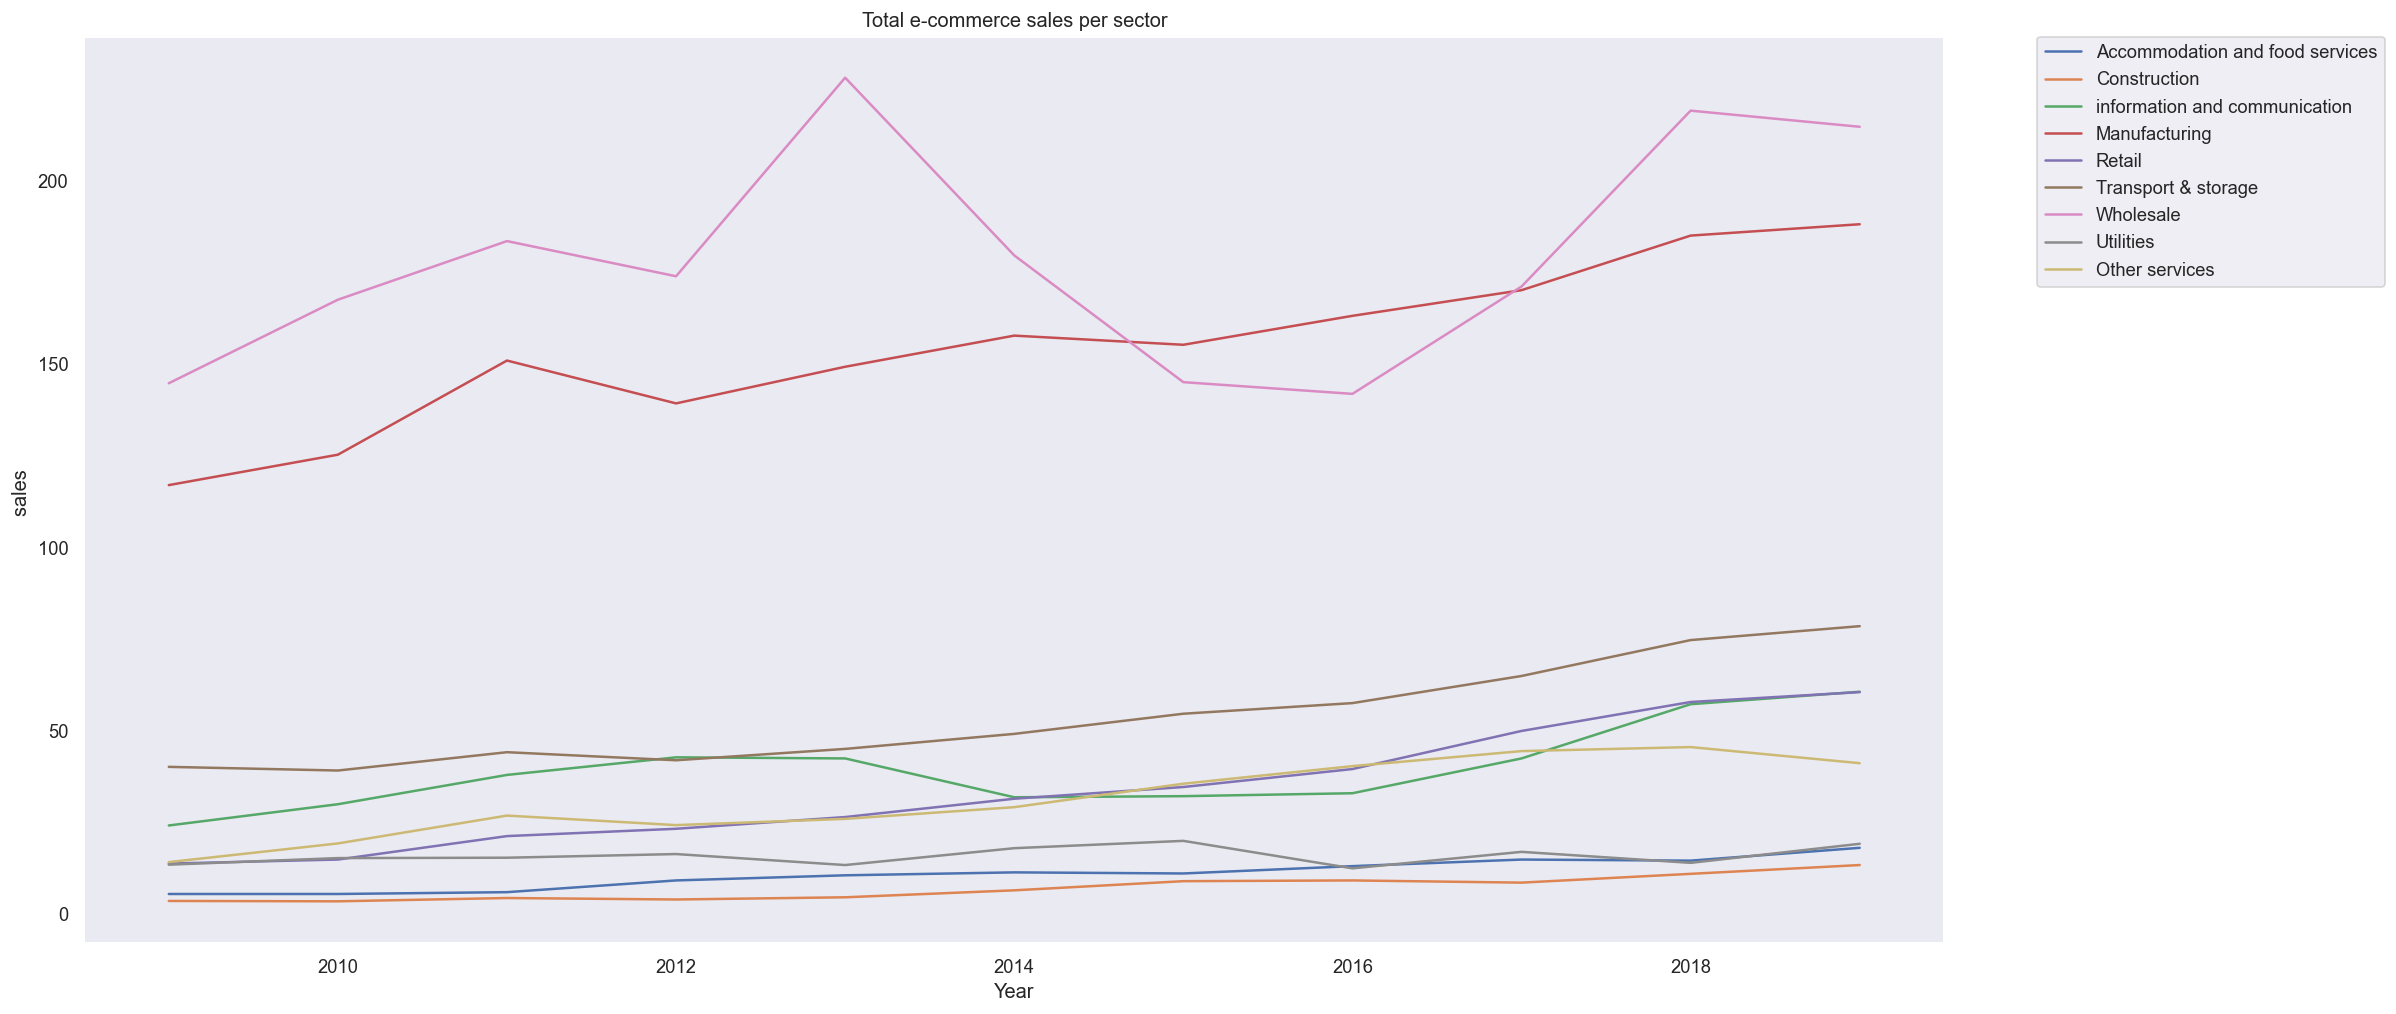

In [291]:

aq=plt.figure(figsize=(20,10))

sns.lineplot(data=per_sec_sales,x="Year",y="Accommodation and food services",label="Accommodation and food services").set_ylabel( "sales ")
sns.lineplot(data=per_sec_sales,x="Year",y="Construction",label="Construction")
sns.lineplot(data=per_sec_sales,x="Year",y="Information and communication",label="information and communication")
sns.lineplot(data=per_sec_sales,x="Year",y='Manufacturing',label="Manufacturing")
sns.lineplot(data=per_sec_sales,x="Year",y='Retail',label="Retail")
sns.lineplot(data=per_sec_sales,x="Year",y='Transport and storage',label="Transport & storage")

sns.lineplot(data=per_sec_sales,x="Year",y='Wholesale',label="Wholesale")
sns.lineplot(data=per_sec_sales,x="Year",y='Utilities',label="Utilities")

sns.lineplot(data=per_sec_sales,x="Year",y='Other services',label="Other services").set(title='Total e-commerce sales per sector')
 
# update legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)





Text(0.5, 1.0, 'Total e-commerce salesin U.K per industry sector')

<Figure size 1800x1200 with 0 Axes>

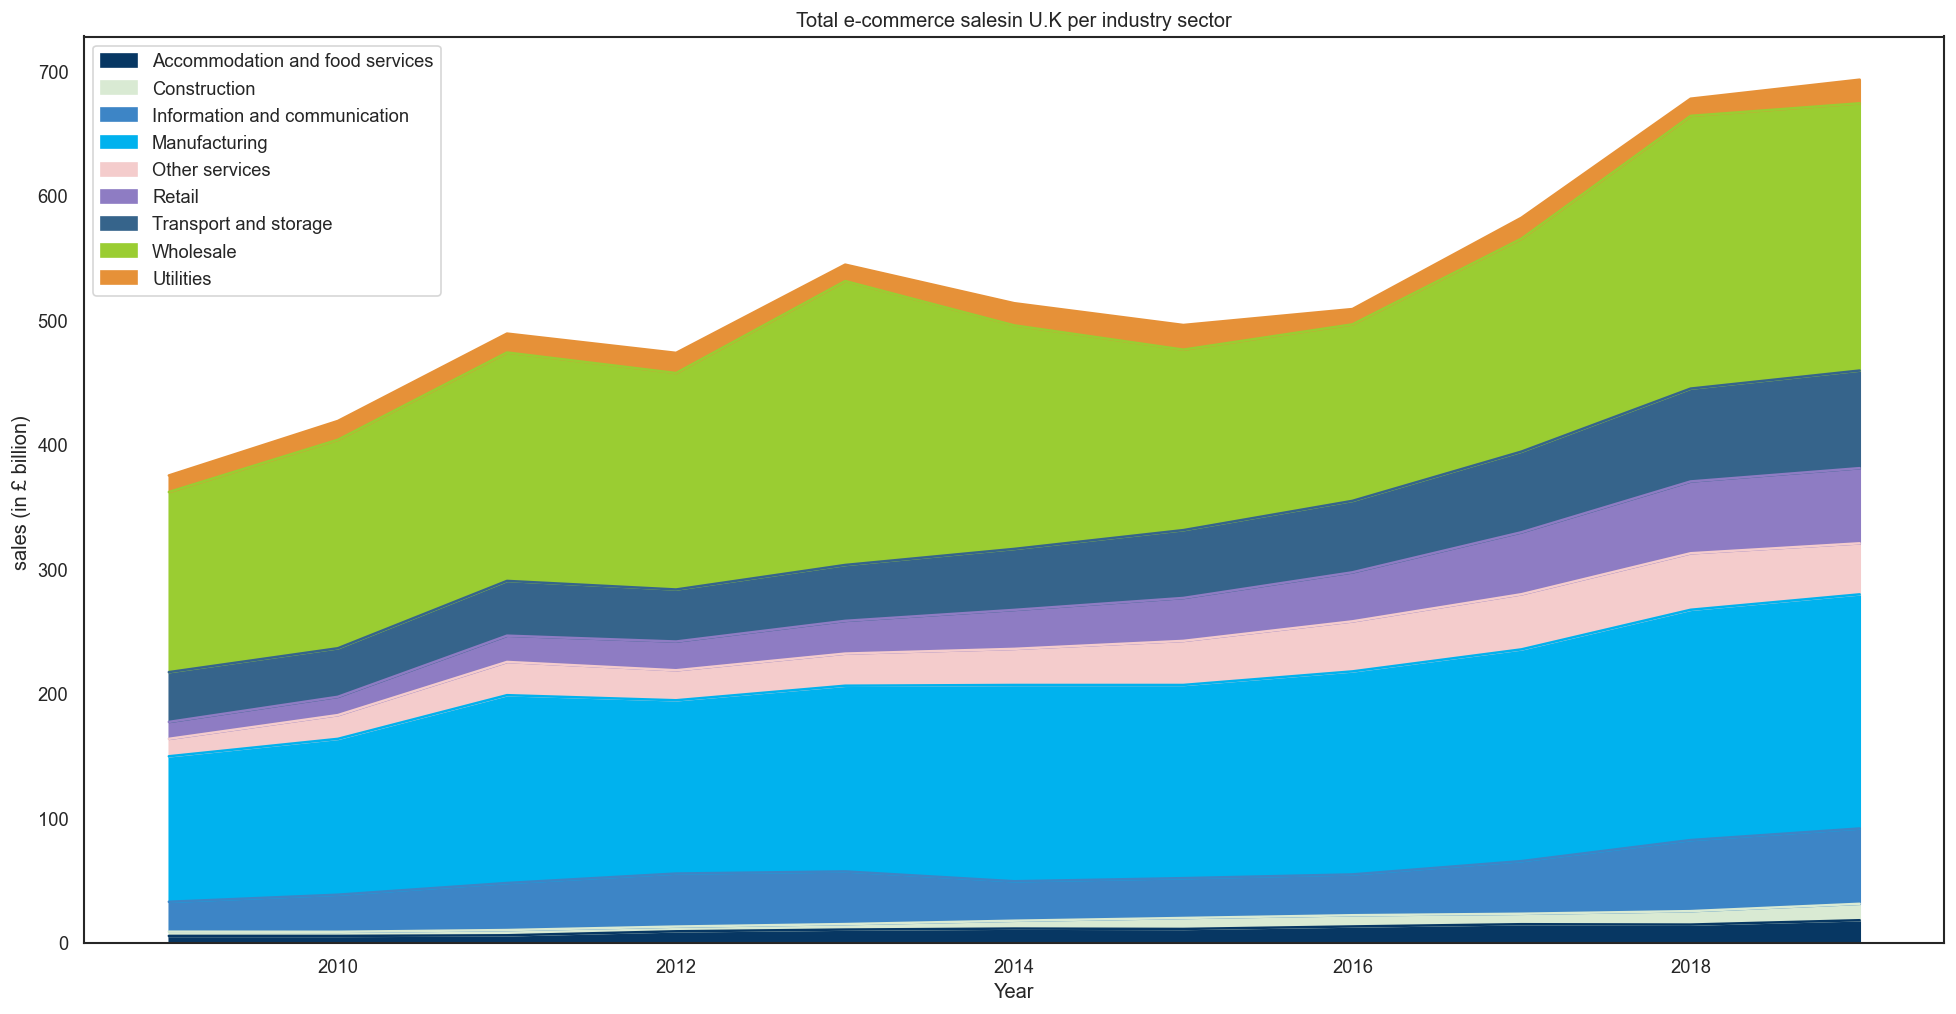

In [292]:
plt.figure(figsize=(15,10))

sns.set(style="white")
color_map = ['#073763', '#d9ead3','#3d85c6','#00b2ee','#f4cccc','#8e7cc3','#36648b','#9acd32','#e69138']
ax = per_sec_sales.plot.area(x='Year',color=color_map,figsize=(20, 10))
ax.set_ylabel( "sales (in £ billion) ")
ax.set_title('Total e-commerce salesin U.K per industry sector')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [295]:
online_retail_total_retail= pd.read_excel('/Users/Apple/Downloads/dataDES/timevsales.xlsx')

In [296]:
online_retail_total_retail.head()



Time Period  Average weekly value for all retailing (£ million)  \
0    2006 Nov                                             5573.3    
1    2006 Dec                                             6729.0    
2    2007 Jan                                             4583.6    
3    2007 Feb                                             4706.6    
4    2007 Mar                                             4905.1    

   Average weekly value for Internet retail sales (£ million)  
0                                              155.7           
1                                              167.9           
2                                              126.0           
3                                              132.7           
4                                              144.2

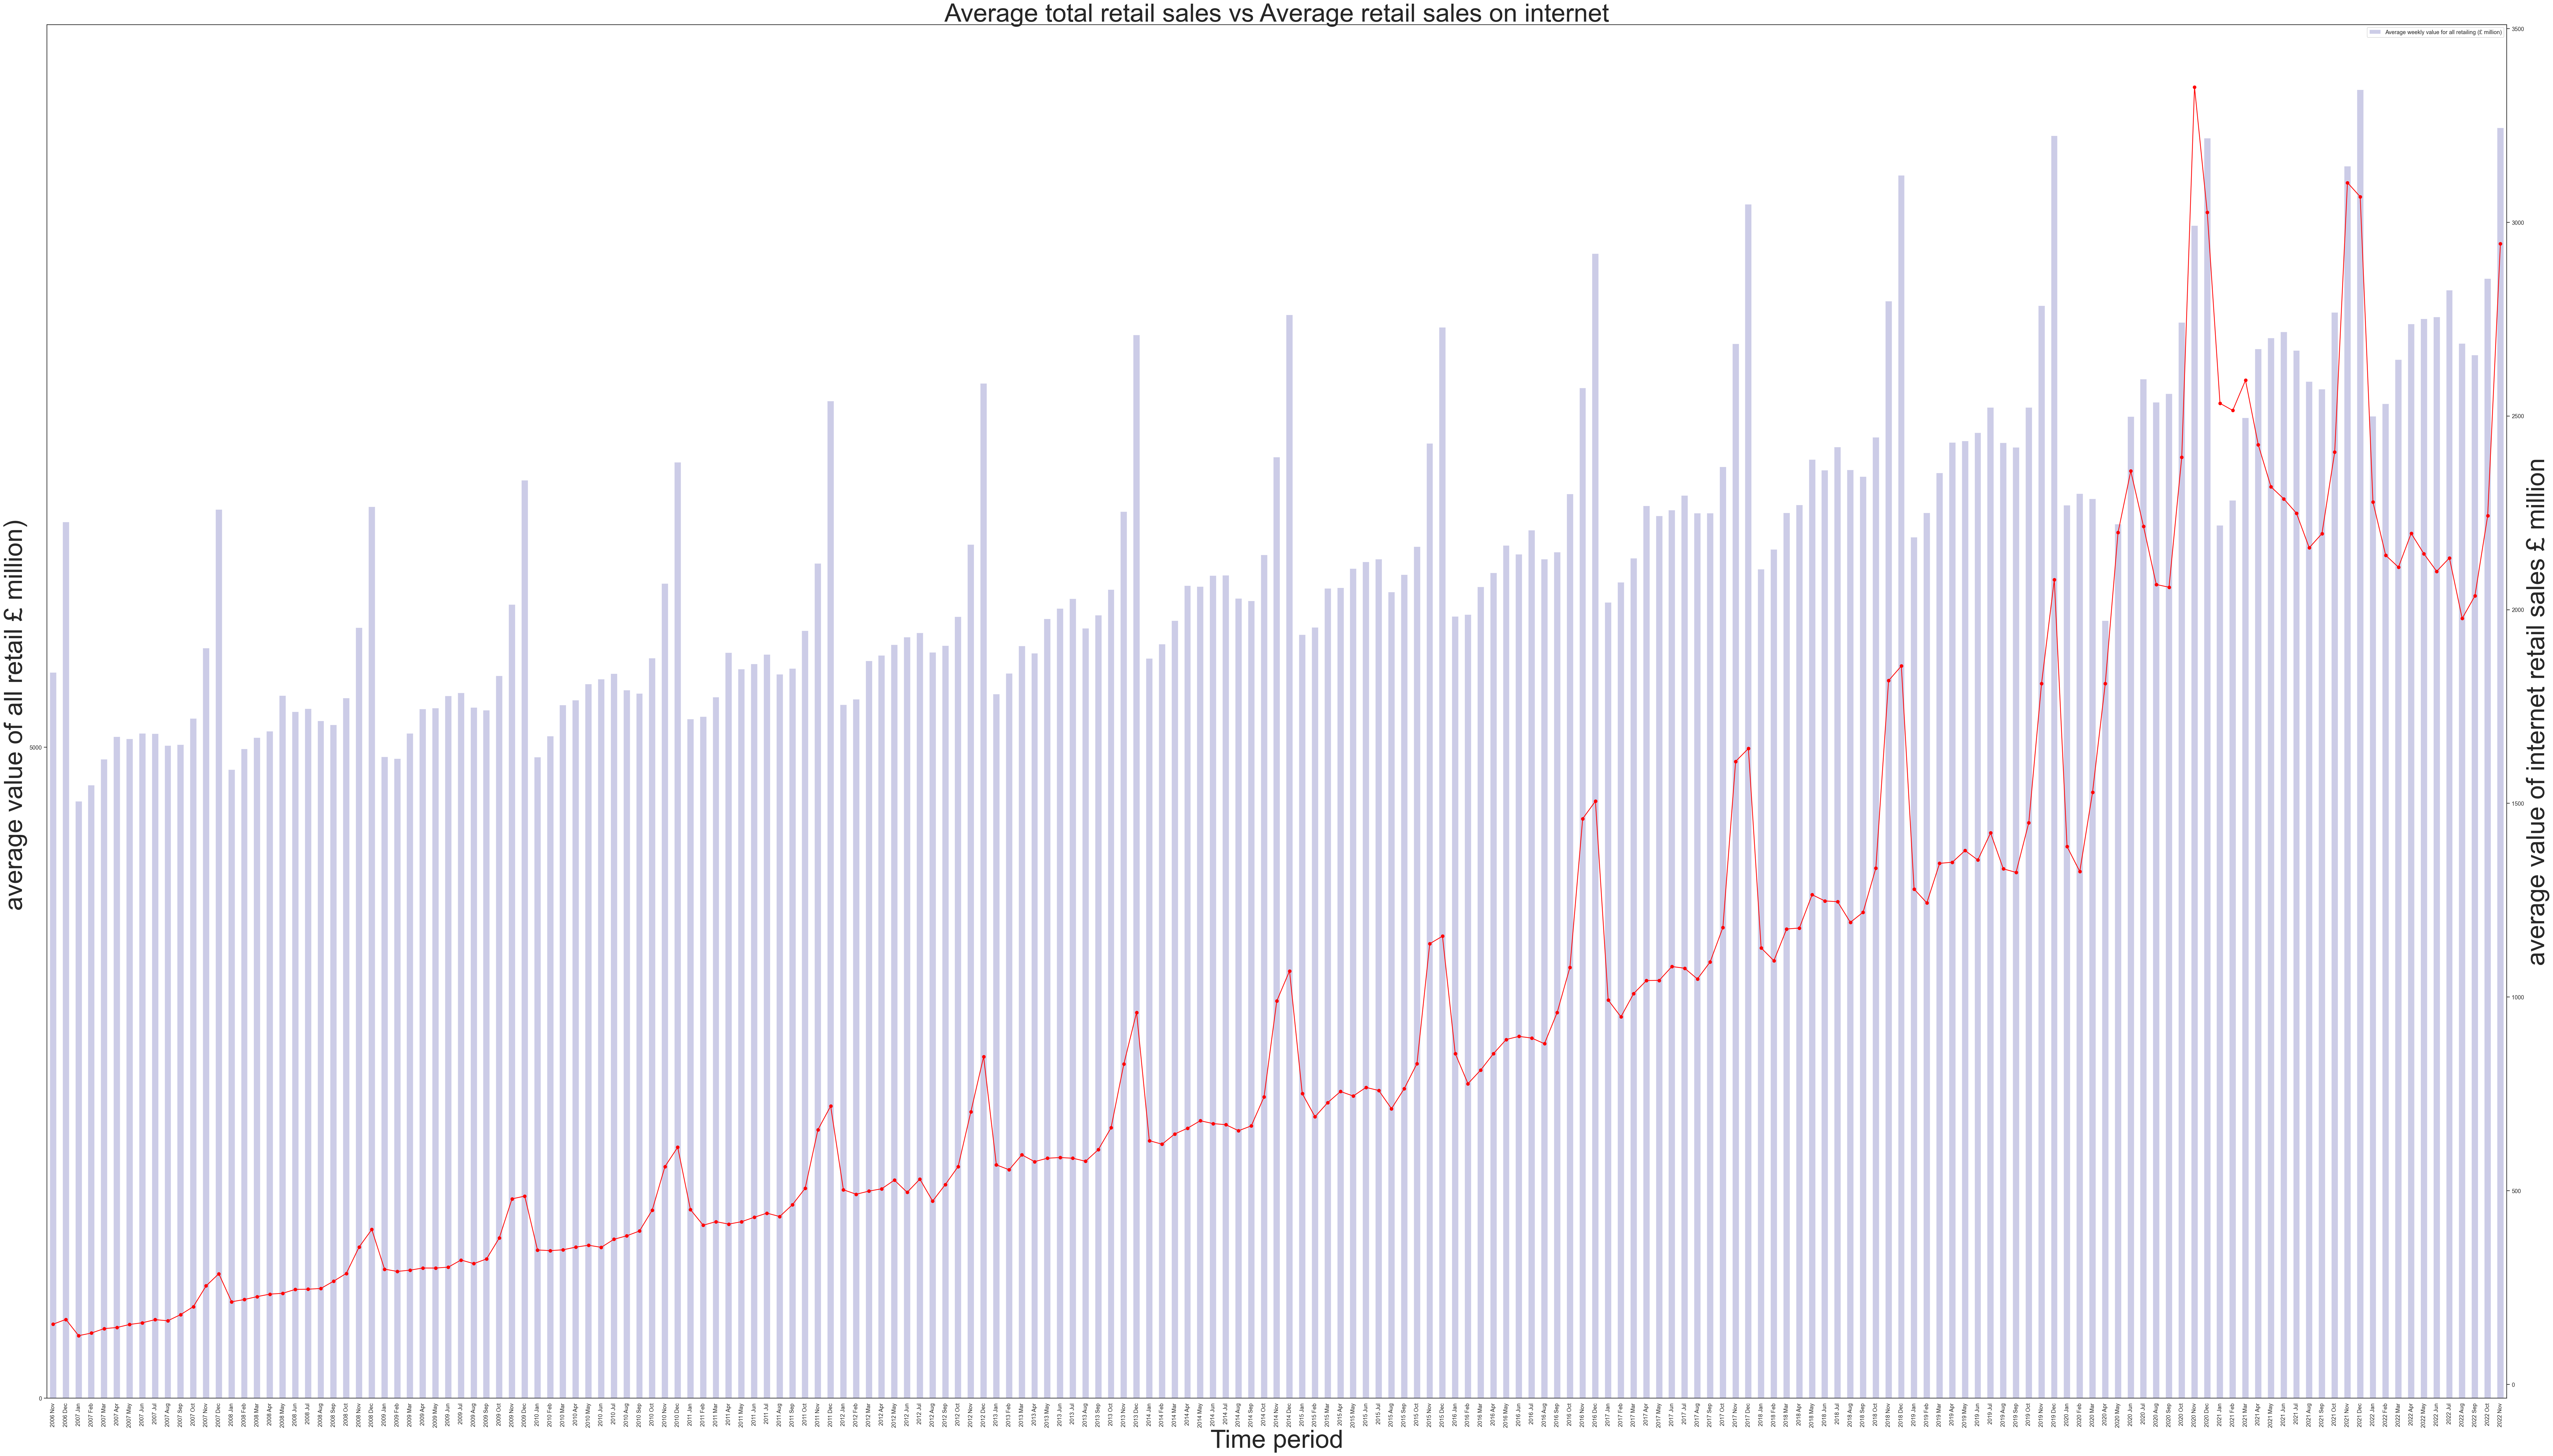

In [348]:


fig, ax = plt.subplots(figsize=(70,40))
ax.set_title('Average total retail sales vs Average retail sales on internet',fontsize=50)
ax2 = ax.twinx()
online_retail_total_retail.plot(x='Time Period', y='Average weekly value for all retailing (£ million)', kind='bar', ax=ax, alpha=0.2, color='DarkBlue')
#ax.set_xticklabels(df4['Time Period'].dt.date, fontsize=8)
ax.get_legend().remove()
ax2.plot(ax.get_xticks(), online_retail_total_retail['Average weekly value for Internet retail sales (£ million)'], color='red',marker='o')
ax.set_ylabel('average value of all retail £ million) ',fontsize=50)
ax.set_xlabel('Time period',fontsize=50)
ax.set_yticks([0, 5000])
ax2.set_ylabel('average value of internet retail sales £ million',fontsize=50)
plt.tight_layout()
ax.legend()
plt.show()


In [360]:
ecomm_per=pd.read_csv('/Users/Apple/Downloads/dataDES/e-com fig.csv')

In [361]:
cor1=ecomm_per.corr()

In [362]:
ecomm_per

Year  Website sales  EDI sales  Total e-commerce sales  \
0  2013           17.7        5.6                    20.6   
1  2014           19.3        5.6                    22.5   
2  2015           18.7        5.0                    21.5   
3  2016           18.5        5.1                    21.5   
4  2017           18.6        5.1                    21.6   
5  2018           22.5        5.9                    25.7   
6  2019           25.4        7.1                    28.6   

   % business_website( 10+ emp)  business with internet access(10+)  \
0                          79.5                                95.1   
1                          80.6                                95.8   
2                          83.0                                95.5   
3                          83.7                                94.7   
4                          81.9                                94.1   
5                          84.0                                95.6   
6                          83.4                                96.1   

   % of people with internet access  
0                              83.3  
1                              85.0  
2                              85.0  
3                              87.9  
4                              88.9  
5                              89.8  
6                              90.8

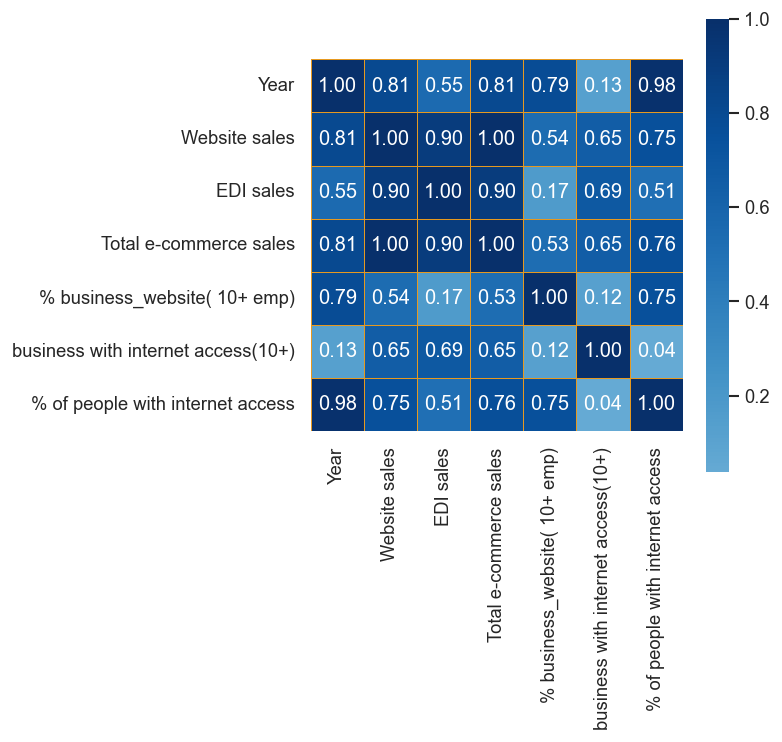

In [363]:

fig, ax = plt.subplots(figsize=(5,5)) 

mask = np.triu(np.ones_like(ecomm_per.corr()))
cmap="Blues"
ax=sns.heatmap(cor1,cmap=cmap,ax=ax,linewidth=0.5, linecolor='#e69920',annot=True,center=0,
            fmt='.2f', square=True)



In [302]:
online_shopping_age= pd.read_excel('/Users/Apple/Downloads/dataDES/per age.xlsx')



Text(0, 0.5, 'percentage')

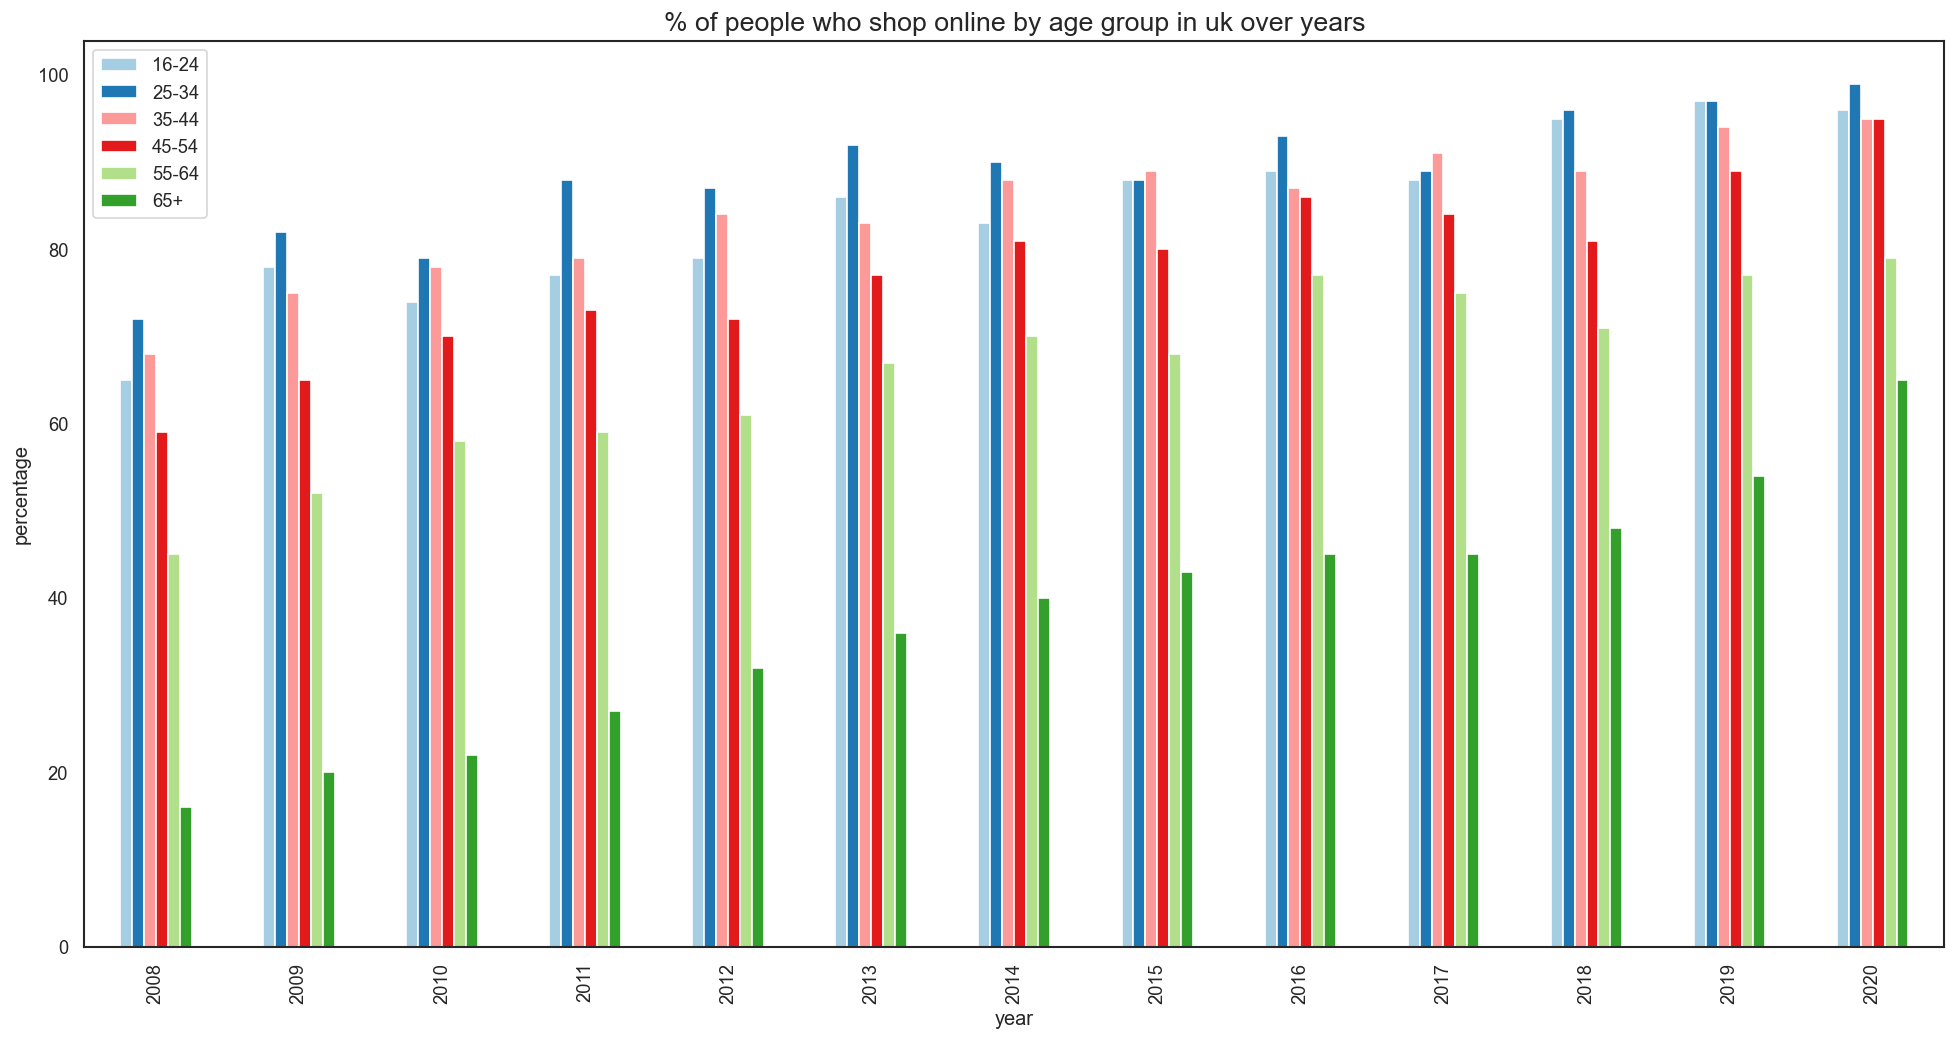

In [303]:

figsize=(50,10)

sns.set(style='white')
a1=online_shopping_age.set_index('year').plot.bar(figsize=(20, 10), color=('#a6cee3','#1f78b4','#fb9a99','#e31a1c','#b2df8a','#33a02c'))
a1.plot()
a1.set_title('% of people who shop online by age group in uk over years', fontsize=16)
a1.set_ylabel('percentage')

#plt.figure(figsize=(50, 10))

In [304]:
items_purchased_online= pd.read_excel('/Users/Apple/Downloads/dataDES/online purch.xlsx')

In [305]:
items_purchased_online

online purchases of  percentage
0   Clothes (including sports clothing), shoes and...          55
1   Deliveries from restaurants, fast-food chains ...          32
2              Printed books, magazines or newspapers          29
3   Furniture, home accessories or gardening products          28
4    Computers, tablets, mobile phones or accessories          24
5                  Children's toys or childcare items          22
6              Cosmetics, beauty or wellness products          22
7      Cleaning products or personal hygiene products          18
8   Consumer electronics, for example TVs, stereos...          18
9            Sports goods (Excluding sports clothing)          17
10  Food or beverages from stores, or from meal-ki...          13
11  Medicine or dietary supplements such as vitamins           13
12                 Physical copies of films or series          13
13                           Physical copies of music          12
14  Bicycles, mopeds, cars, or other vehicles or t...           8

In [ ]:
items_purchased_online

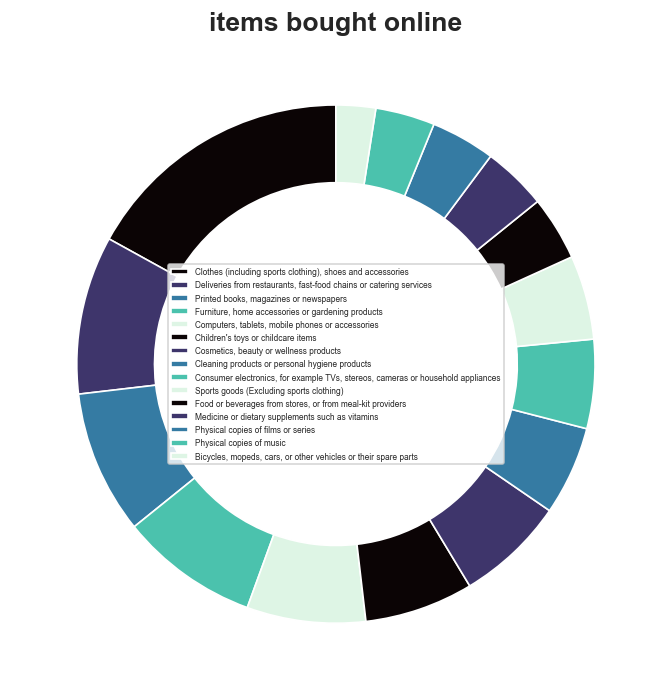

In [316]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
cs_customer= cm.get_cmap('mako')(np.linspace(0, 1, 5))
component = items_purchased_online['online purchases of']
data = items_purchased_online['percentage']

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.3),startangle=90,colors=cs_customer)

plt.legend(wedges, component, loc="center",fontsize=5)

ax.set_title("items bought online",fontdict={'fontsize': 16, 'fontweight': 'bold'})

fig.tight_layout()
plt.savefig('donutplot2.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

In [317]:
df8= pd.read_excel('/Users/Apple/Downloads/ecom compilation.xlsx')

In [318]:
df8

Year  Sales over a website  Sales over EDI  \
0  2012                 172.9           300.7   
1  2013                 198.0           346.8   
2  2014                 210.4           284.1   
3  2015                 218.1           257.2   
4  2016                 230.4           255.0   
5  2017                 275.4           279.9   
6  2018                 322.3           317.3   
7  2019                 334.9           334.0   

   Total e-commerce sales in £ billion  10 to 49 _emp_sales  \
0                                473.6                 27.5   
1                                544.7                 29.1   
2                                494.5                 29.4   
3                                475.4                 31.2   
4                                485.4                 36.6   
5                                555.2                 47.0   
6                                639.7                 56.5   
7                                668.9                 50.0   

   50 to 249 _emp_sales  250 to 999_emp_sales  1000 or more_emp_sales  \
0                  55.5                 157.7                   232.9   
1                  53.8                 212.9                   249.0   
2                  51.0                 158.1                   256.0   
3                  62.0                 116.6                   265.6   
4                  64.7                 107.9                   276.3   
5                  83.3                 127.5                   297.5   
6                  99.7                 153.9                   329.6   
7                  94.8                 155.6                   368.5   

   sales_Accommodation and foodser_sec  sales_Construction_sec  \
0                                  9.0                     3.8   
1                                 10.4                     4.4   
2                                 11.2                     6.3   
3                                 10.9                     8.8   
4                                 12.9                     9.0   
5                                 14.7                     8.4   
6                                 14.4                    10.8   
7                                 17.9                    13.2   

   sales_Information&communication_sec  sales_manufacturing_sec  \
0                                 42.6                    139.2   
1                                 42.3                    149.2   
2                                 31.7                    157.7   
3                                 32.0                    155.2   
4                                 32.8                    163.1   
5                                 42.3                    170.1   
6                                 57.1                    185.0   
7                                 60.5                    188.1   

   sales_Otherservices_sec  sales_retail_sec  sales_transportandstorage_sec  \
0                     24.1              23.1                           41.8   
1                     25.8              26.3                           44.9   
2                     29.0              31.3                           49.0   
3                     35.4              34.5                           54.5   
4                     40.2              39.4                           57.4   
5                     44.3              49.8                           64.8   
6                     45.4              57.7                           74.6   
7                     41.0              60.4                           78.4   

   sales_wholesale_sec  sales_utilities_sec  Sales to private customers   \
0                173.9                 16.2                        100.2   
1                228.1                 13.2                         94.8   
2                179.6                 17.8                        119.3   
3                145.0                 19.8                        118.5   
4                141.8                 12.3 

In [319]:
corr=df8.corr()
corr

Year  Sales over a website  \
Year                                    1.000000              0.967036   
Sales over a website                    0.967036              1.000000   
Sales over EDI                          0.060762              0.276948   
Total e-commerce sales in £ billion     0.780776              0.903124   
10 to 49 _emp_sales                     0.918597              0.960969   
50 to 249 _emp_sales                    0.914738              0.963026   
250 to 999_emp_sales                   -0.365190             -0.158781   
1000 or more_emp_sales                  0.955682              0.980473   
sales_Accommodation and foodser_sec     0.956791              0.945669   
sales_Construction_sec                  0.961045              0.908024   
sales_Information&communication_sec     0.610798              0.771804   
sales_manufacturing_sec                 0.975034              0.987168   
sales_Otherservices_sec                 0.926890              0.851581   
sales_retail_sec                        0.985136              0.991683   
sales_transportandstorage_sec           0.986841              0.991212   
sales_wholesale_sec                     0.186202              0.403927   
sales_utilities_sec                     0.127477              0.113702   
Sales to private customers              0.964400              0.986107   
Sales to businesses/public authorities  0.950879              0.969577   
#people used internet in last 3 months  0.991519              0.934482   

                                        Sales over EDI  \
Year                                          0.060762   
Sales over a website                          0.276948   
Sales over EDI                                1.000000   
Total e-commerce sales in £ billion           0.662702   
10 to 49 _emp_sales                           0.234461   
50 to 249 _emp_sales                          0.266170   
250 to 999_emp_sales                          0.875908   
1000 or more_emp_sales                        0.306320   
sales_Accommodation and foodser_sec           0.213977   
sales_Construction_sec                       -0.005636   
sales_Information&communication_sec           0.729508   
sales_manufacturing_sec                       0.211877   
sales_Otherservices_sec                      -0.190534   
sales_retail_sec                              0.165750   
sales_transportandstorage_sec                 0.170101   
sales_wholesale_sec                           0.964071   
sales_utilities_sec                          -0.159475   
Sales to private customers                    0.187678   
Sales to businesses/public authorities        0.213676   
#people used internet in last 3 months       -0.032936   

                                        Total e-commerce sales in £ billion  \
Year                                                               0.780776   
Sales over a website                                               0.903124   
Sales over EDI                                                     0.662702   
Total e-commerce sales in £ billion                                1.000000   
10 to 49 _emp_sales                                                0.853698   
50 to 249 _emp_sales                                               0.869527   
250 to 999_emp_sales                                               0.267636   
1000 or more_emp_sales                                             0.901036   
sales_Accommodation and foodser_sec                                0.832435   
sales_Construction_sec                                             0.705280   
sales_Information&communication_sec                                0.927611   
sales_manufacturing_sec                                            0.864045   
sales_Otherservices_sec                                            0.578451   
sales_retail_sec                                                   0.846914   
sales_transportandstorage_sec                                      0.848551   
sales_

In [320]:
df8.describe()

Year  Sales over a website  Sales over EDI  \
count     8.00000               8.00000         8.00000   
mean   2015.50000             245.30000       296.87500   
std       2.44949              59.18745        33.97805   
min    2012.00000             172.90000       255.00000   
25%    2013.75000             207.30000       274.22500   
50%    2015.50000             224.25000       292.40000   
75%    2017.25000             287.12500       321.47500   
max    2019.00000             334.90000       346.80000   

       Total e-commerce sales in £ billion  10 to 49 _emp_sales  \
count                             8.000000             8.000000   
mean                            542.175000            38.412500   
std                              75.973788            11.196356   
min                             473.600000            27.500000   
25%                             482.900000            29.325000   
50%                             519.600000            33.900000   
75%                             576.325000            47.750000   
max                             668.900000            56.500000   

       50 to 249 _emp_sales  250 to 999_emp_sales  1000 or more_emp_sales  \
count              8.000000              8.000000                8.000000   
mean              70.600000            148.775000              284.425000   
std               19.261064             32.754705               45.384823   
min               51.000000            107.900000              232.900000   
25%               55.075000            124.775000              254.250000   
50%               63.350000            154.750000              270.950000   
75%               86.175000            157.800000              305.525000   
max               99.700000            212.900000              368.500000   

       sales_Accommodation and foodser_sec  sales_Construction_sec  \
count                             8.000000                8.000000   
mean                             12.675000                8.087500   
std                               2.889266                3.164733   
min                               9.000000                3.800000   
25%                              10.775000                5.825000   
50%                              12.050000                8.600000   
75%                              14.475000                9.450000   
max                              17.900000               13.200000   

       sales_Information&communication_sec  sales_manufacturing_sec  \
count                             8.000000                 8.000000   
mean                             42.662500               163.450000   
std                              11.071319                16.939472   
min                              31.700000               139.200000   
25%                              32.600000               153.700000   
50%                              42.300000               160.400000   
75%                              46.225000               173.825000   
max                              60.500000               188.100000   

       sales_Otherservices_sec  sales_retail_sec  \
count                    8.000          8.000000   
mean                    35.650         40.312500   
std                      8.400         14.163881   
min                     24.100         23.100000   
25%                     28.200         30.050000   
50%                     37.800         36.950000   
75%                     41.825         51.775000   
max                     45.400         60.400000   

       sales_transportandstorage_sec  sales_wholesale_sec  \
count                       8.000000              8.00000   
mean                       58.175000            184.16250   
std                        13.444994             33.18502   
min                        41.800000            141.80000   
25%                        47.975000            164.57500   
50%                        55.950000            176.75000   
75%             

<AxesSubplot:>

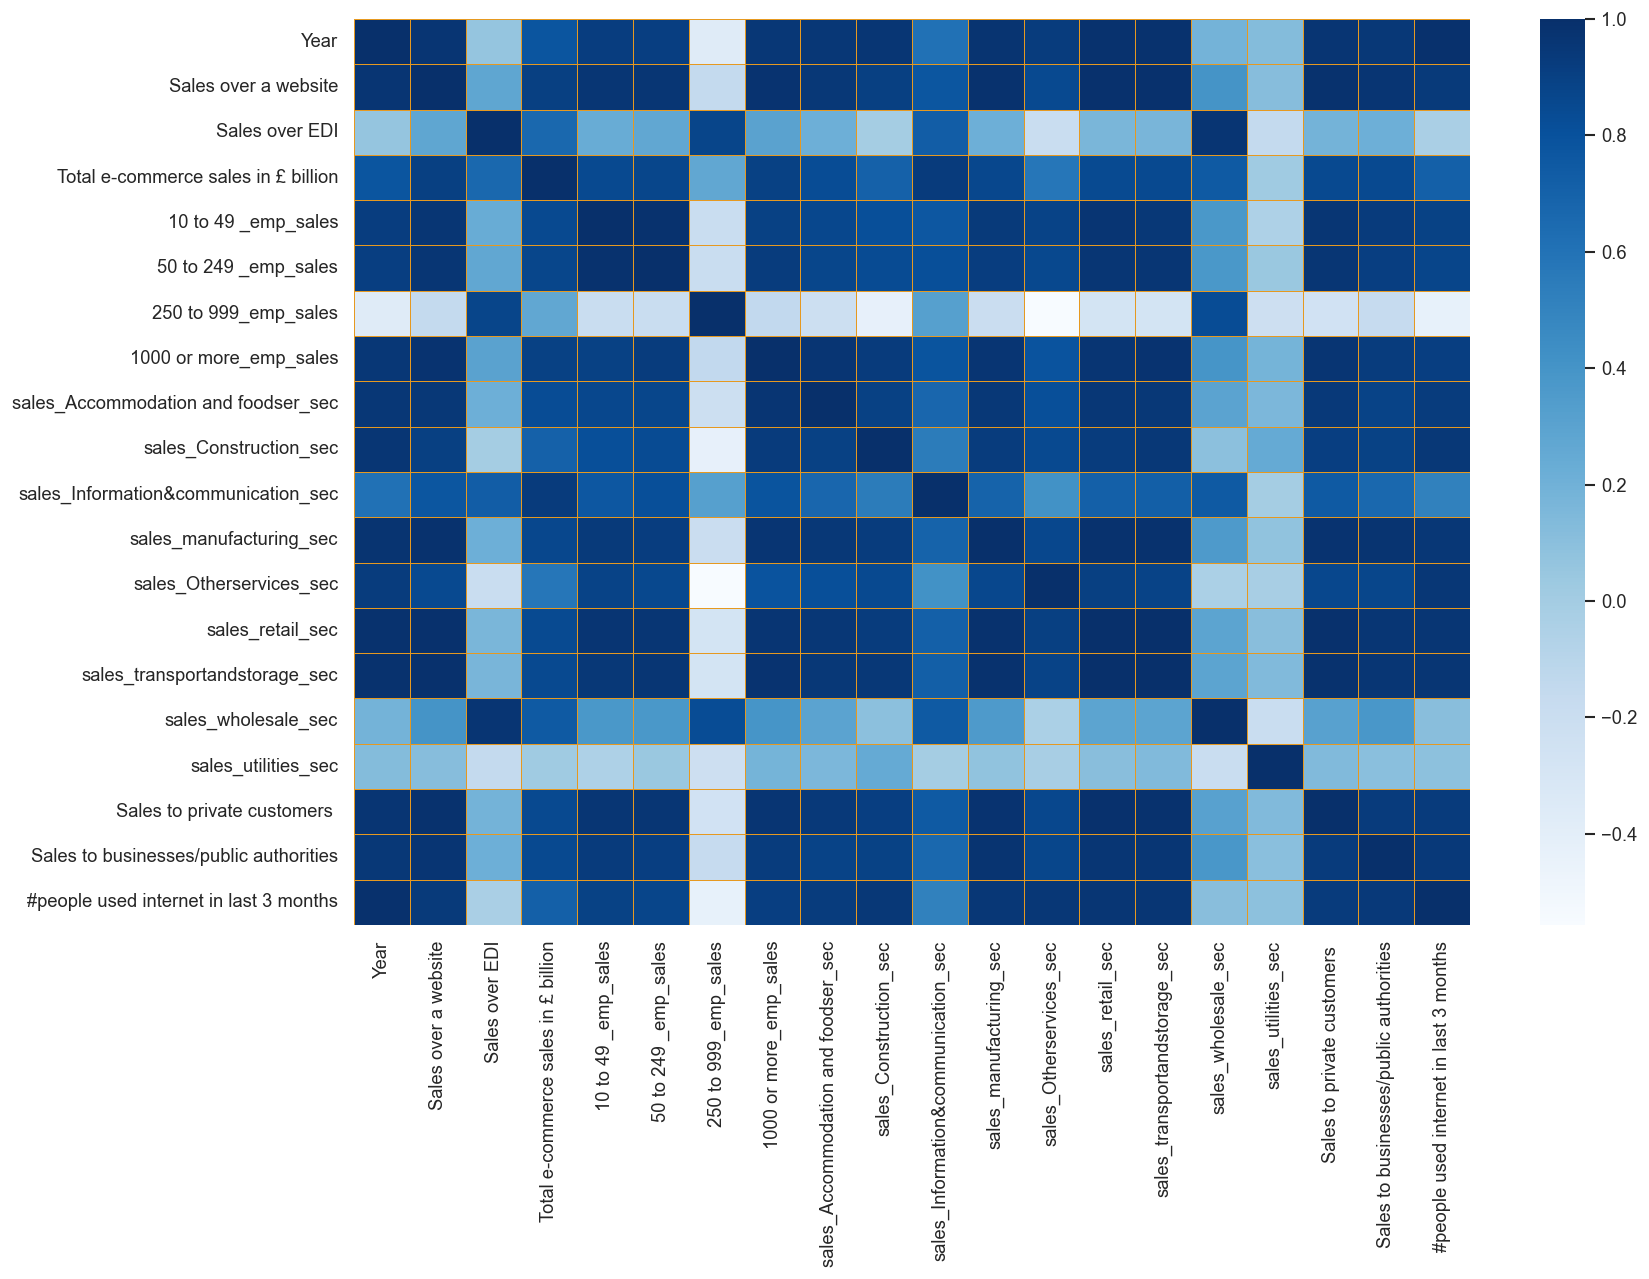

In [322]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10)) 


cmap="Blues"
sns.heatmap(corr,cmap=cmap,ax=ax,linewidth=0.5, linecolor='#e69920')

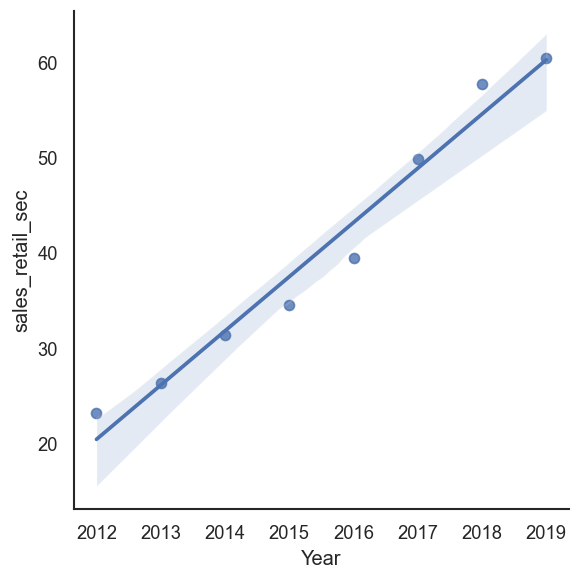

In [323]:
sns.lmplot(x="Year", y="sales_retail_sec", data=df8);

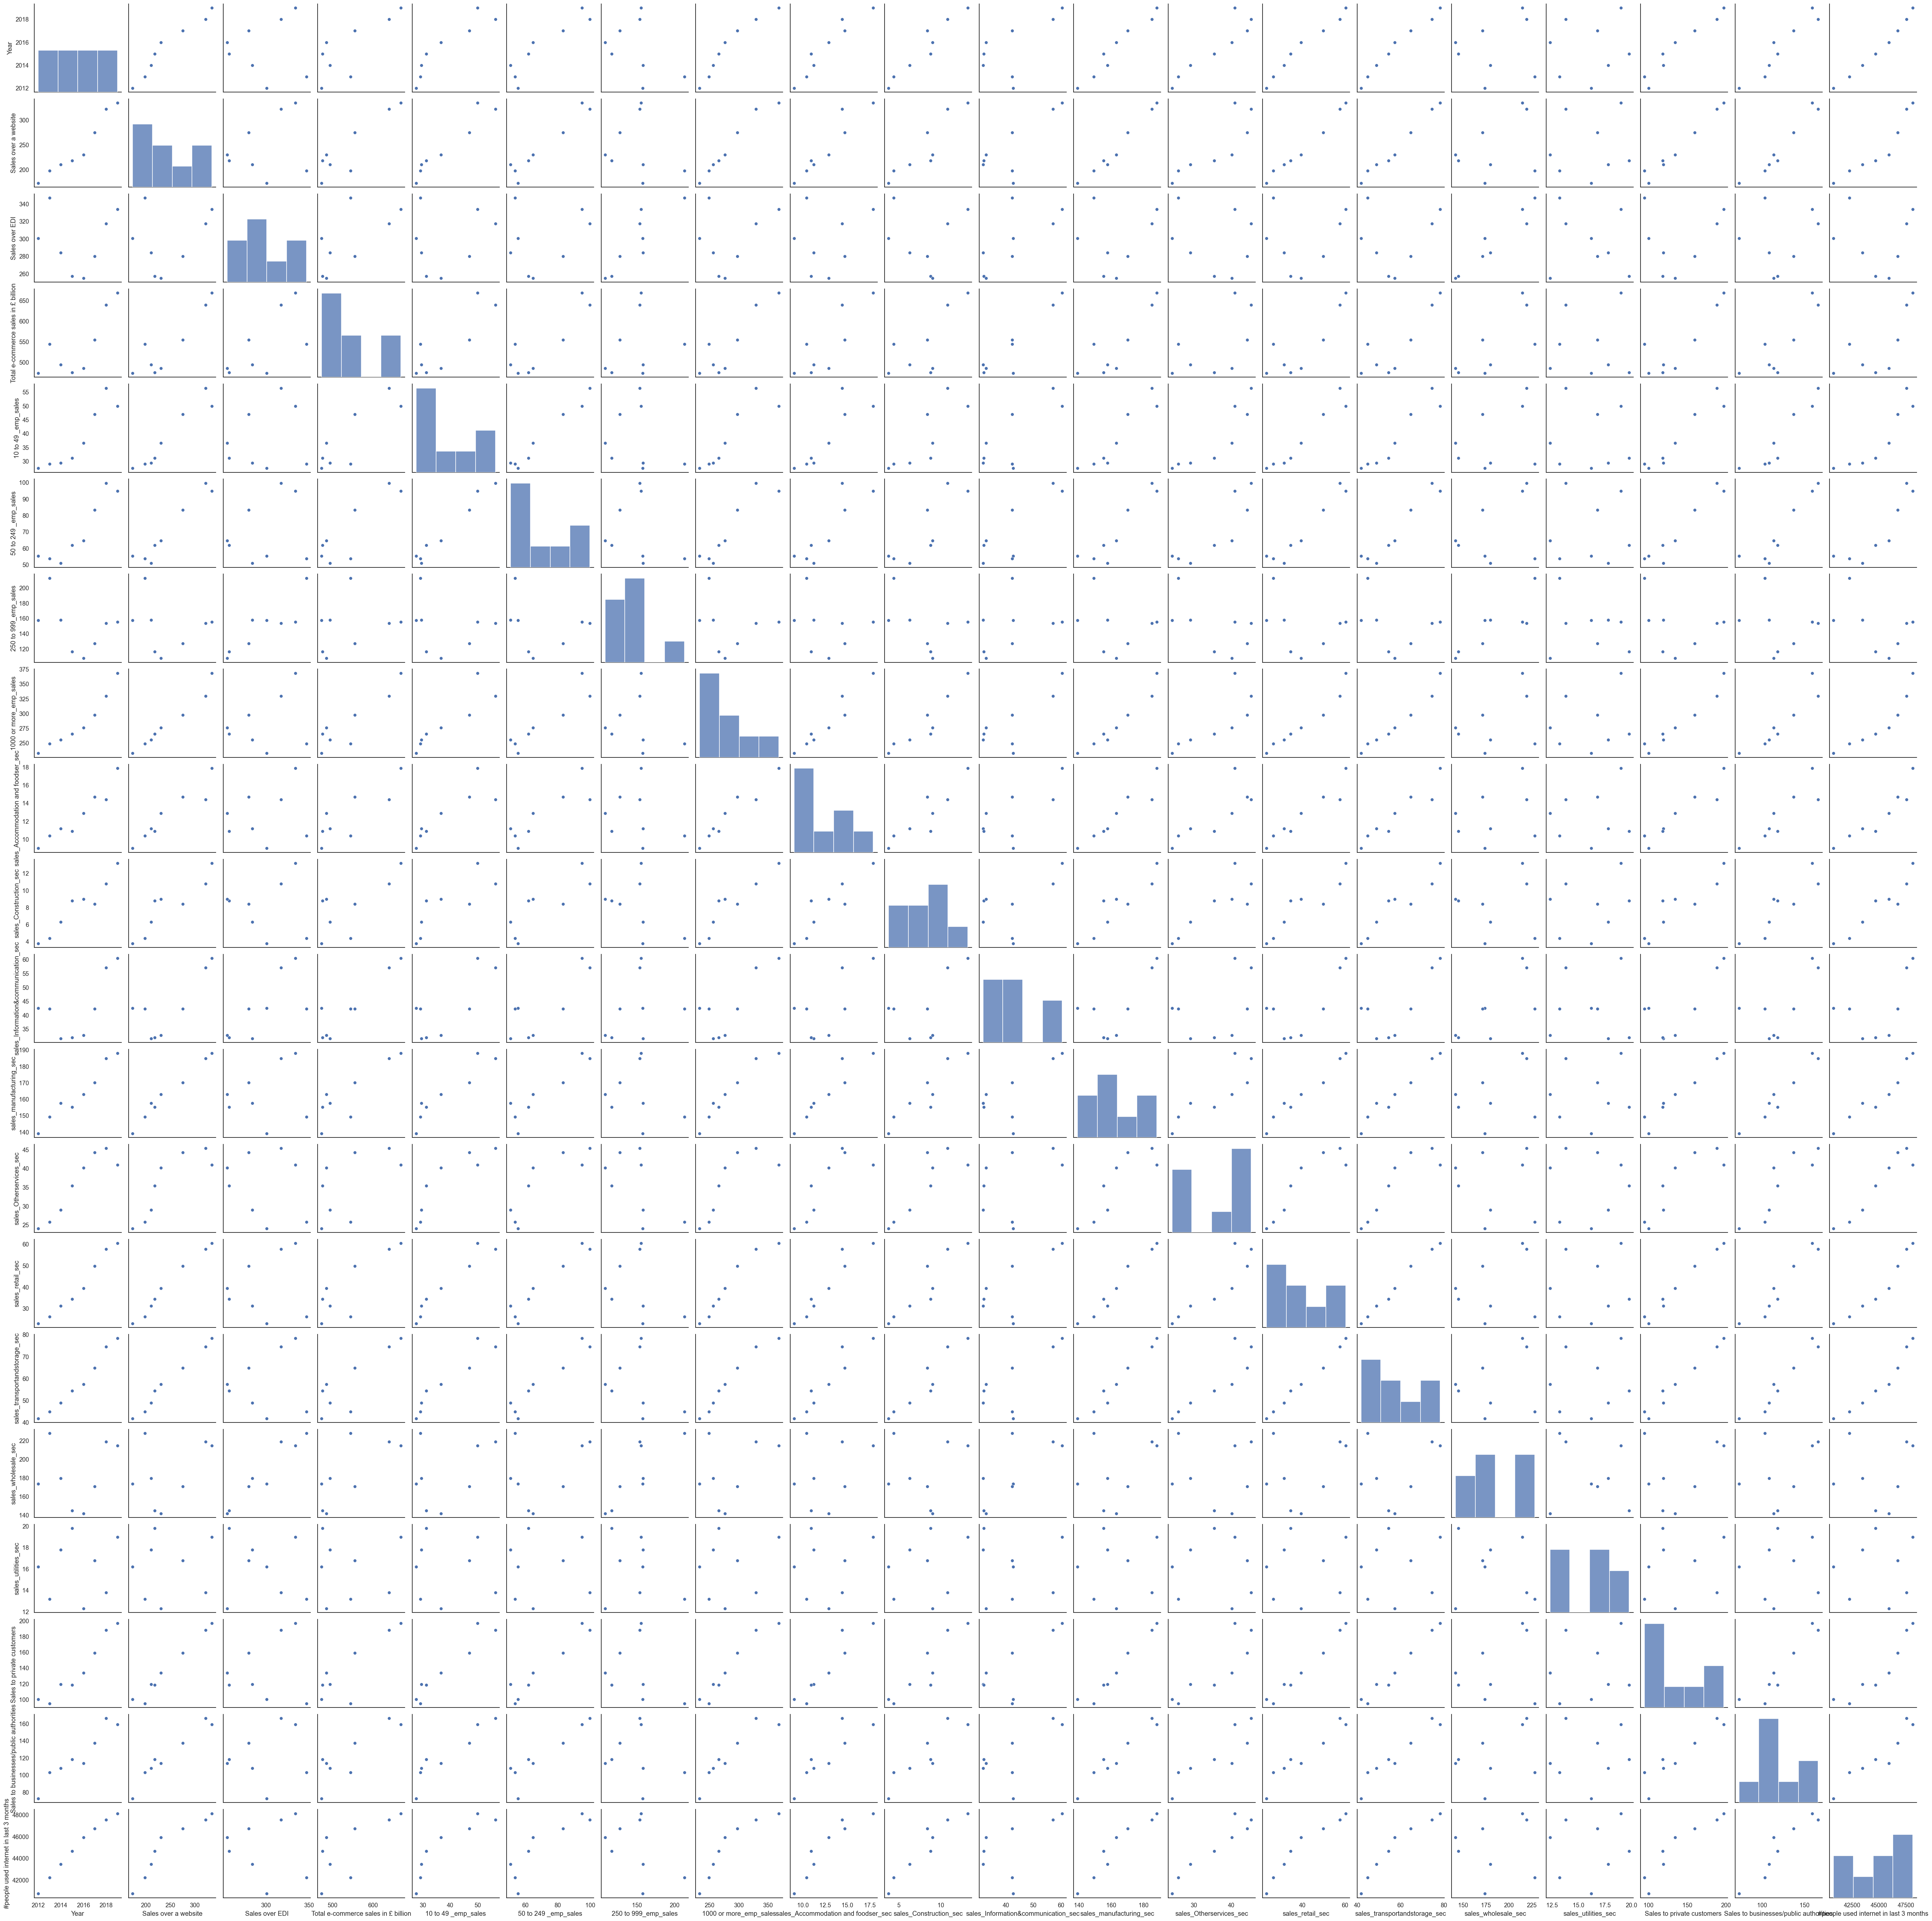

In [324]:
sns.pairplot(df8)

In [ ]:
#internet and shopping online age & gender

In [325]:
online_shopping_age_gender=pd.read_csv('/Users/Apple/Downloads/dataDES/frq of onlineshoppingby gender&age.csv')

In [326]:
online_shopping_age_gender.head(10)

Year  All  Men  Women  ages 16-24  ages 25-34  ages 35-44  ages 45-54  \
0  2008   53   57     49          65          72          68          59   
1  2009   61   66     57          78          82          75          65   
2  2010   62   64     60          74          79          78          70   
3  2011   66   68     63          77          88          79          73   
4  2012   67   68     67          79          87          84          72   
5  2013   72   74     70          86          92          83          77   
6  2014   74   75     72          83          90          88          81   
7  2015   74   75     74          88          88          89          80   
8  2016   77   78     77          89          93          87          86   
9  2017   77   77     76          88          89          91          84   

   ages 55-64  ages 65+  
0          45        16  
1          52        20  
2          58        22  
3          59        27  
4          61        32  
5          67        36  
6          70        40  
7          68        43  
8          77        45  
9          75        45

In [327]:
onlineshopping_gender=online_shopping_age_gender.drop(['All','ages 16-24', 'ages 25-34','ages 35-44','ages 45-54','ages 55-64','ages 65+'], axis=1)

In [328]:
onlineshopping_gender

Year  Men  Women
0   2008   57     49
1   2009   66     57
2   2010   64     60
3   2011   68     63
4   2012   68     67
5   2013   74     70
6   2014   75     72
7   2015   75     74
8   2016   78     77
9   2017   77     76
10  2018   78     78
11  2019   83     82
12  2020   87     87

In [329]:
onlineshopping_ages=online_shopping_age_gender.drop(['Men','Women'], axis=1)

(0.0, 250.0)

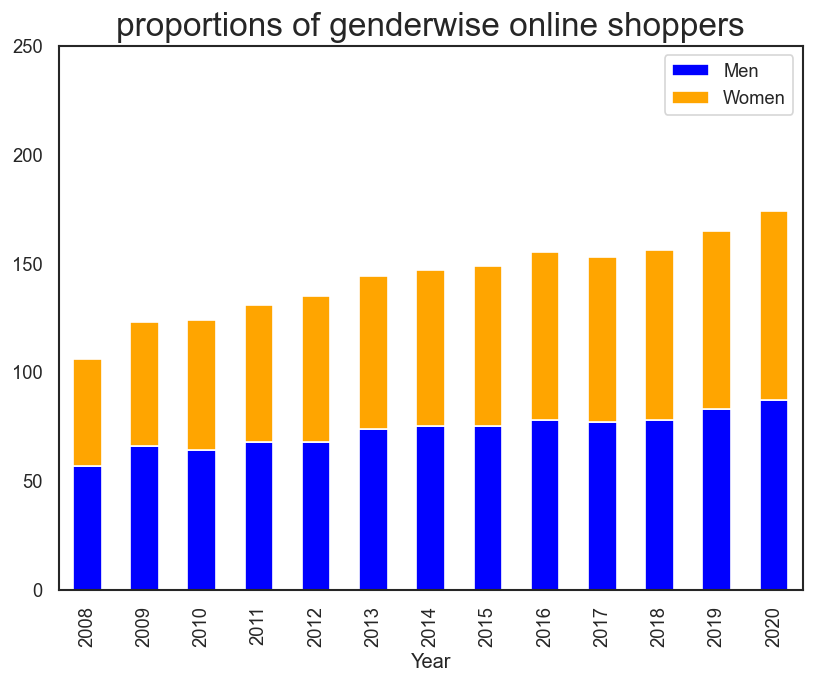

In [330]:
ax = onlineshopping_gender.plot.bar(x='Year', stacked=True, color=['Blue','Orange'], figsize=(8,6))
ax.set_title('proportions of genderwise online shoppers', fontsize=20)
ax.set_ylim(0,250)

In [331]:
numberoftime_people_shop_online=pd.read_csv('/Users/Apple/Downloads/dataDES/num of timeshopper shops .csv')

In [332]:
numberoftime_people_shop_online

Times purchased in last 3 month  total percentage  16-24  25-34  35-44  \
0                   Once or twice                16     25     11     12   
1             Three to five times                30     30     26     23   
2                Six to ten times                19     20     18     20   
3            Eleven times or more                34     24     43     44   

   45-54  55-64  65+  Men  Women  
0      9     19   26   18     15  
1     36     25   39   28     32  
2     17     22   19   20     18  
3     37     34   15   34     34

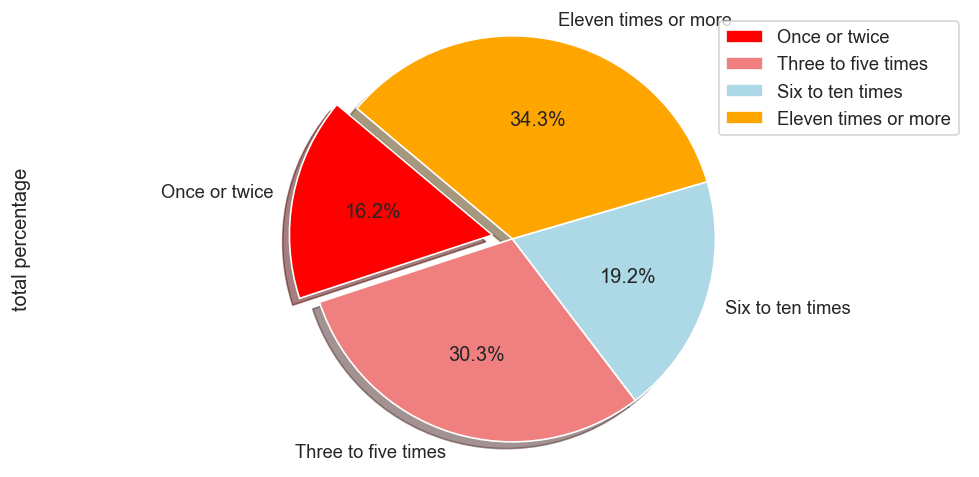

In [336]:
numberoftime_people_shop_online.plot.pie(y='total percentage',autopct='%1.1f%%',shadow=True, startangle=140,explode=explode,colors = ['red', 'lightcoral', 'lightblue','orange'], figsize=(10,5),labels=numberoftime_people_shop_online['Times purchased in last 3 month'])
plt.axis('equal')
plt.show()
# update legend
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
##########


#######

In [337]:
totalval_online_purchases=pd.read_csv('/Users/Apple/Downloads/dataDES/value of online purchases.csv')

In [338]:
totalval_online_purchases=totalval_online_purchases.dropna()

In [339]:
totalval_online_purchases

Total value of online purchases  16-24  25-34  35-44  45-54  55-64   65+  \
0                            <£50   17.0    8.0   12.0   13.0   10.0  19.0   
1                         £50-£99   29.0   14.0   12.0   22.0   15.0  19.0   
2                       £100-£499   38.0   44.0   40.0   35.0   46.0  47.0   
3                       £500-£999    8.0   22.0   14.0   14.0   13.0   6.0   
4                         £1,000+    6.0   10.0   18.0   16.0   13.0   6.0   

    Men  Women  total percentage  
0  12.0   14.0              13.0  
1  14.0   23.0              18.0  
2  45.0   39.0              42.0  
3  14.0   13.0              14.0  
4  14.0    9.0              12.0

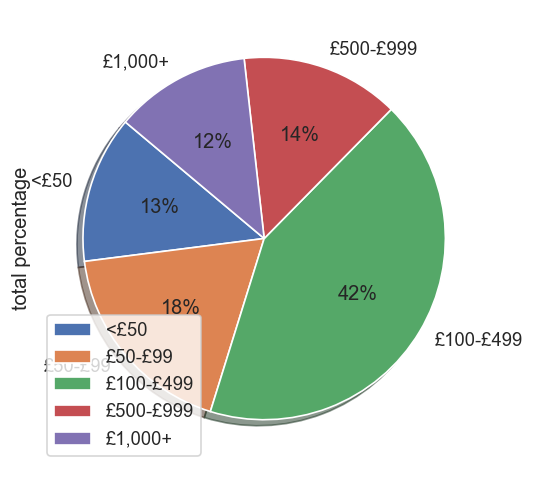

In [340]:
#explode = (0.1, 0, 0, 0)
totalval_online_purchases.plot.pie(y='total percentage',autopct='%1.0f%%', figsize=(10,5), shadow=True, startangle=140,labels=totalval_online_purchases['Total value of online purchases'])
plt.show()

In [341]:
items_purchased_online=pd.read_csv('/Users/Apple/Downloads/dataDES/itemspurchased.csv')

In [342]:
items_purchased_online

Items purchased  percentage
0                       Clothes,shoes and accessories          55
1                                       Food delivery          32
2              Printed books, magazines or newspapers          29
3   Furniture, home accessories or gardening products          28
4    Computers, tablets, mobile phones or accessories          24
5                  Children's toys or childcare items          22
6              Cosmetics, beauty or wellness products          22
7      Cleaning products or personal hygiene products          18
8                                Consumer electronics          18
9                                       Sports goods           17
10  Food or beverages from stores, or from meal-ki...          13
11  Medicine or dietary supplements such as vitamins           13
12                 Physical copies of films or series          13
13                           Physical copies of music          12
14  Bicycles, mopeds, cars, or other vehicles or t...           8

Text(0.5, 1.0, '%of items purchased online')

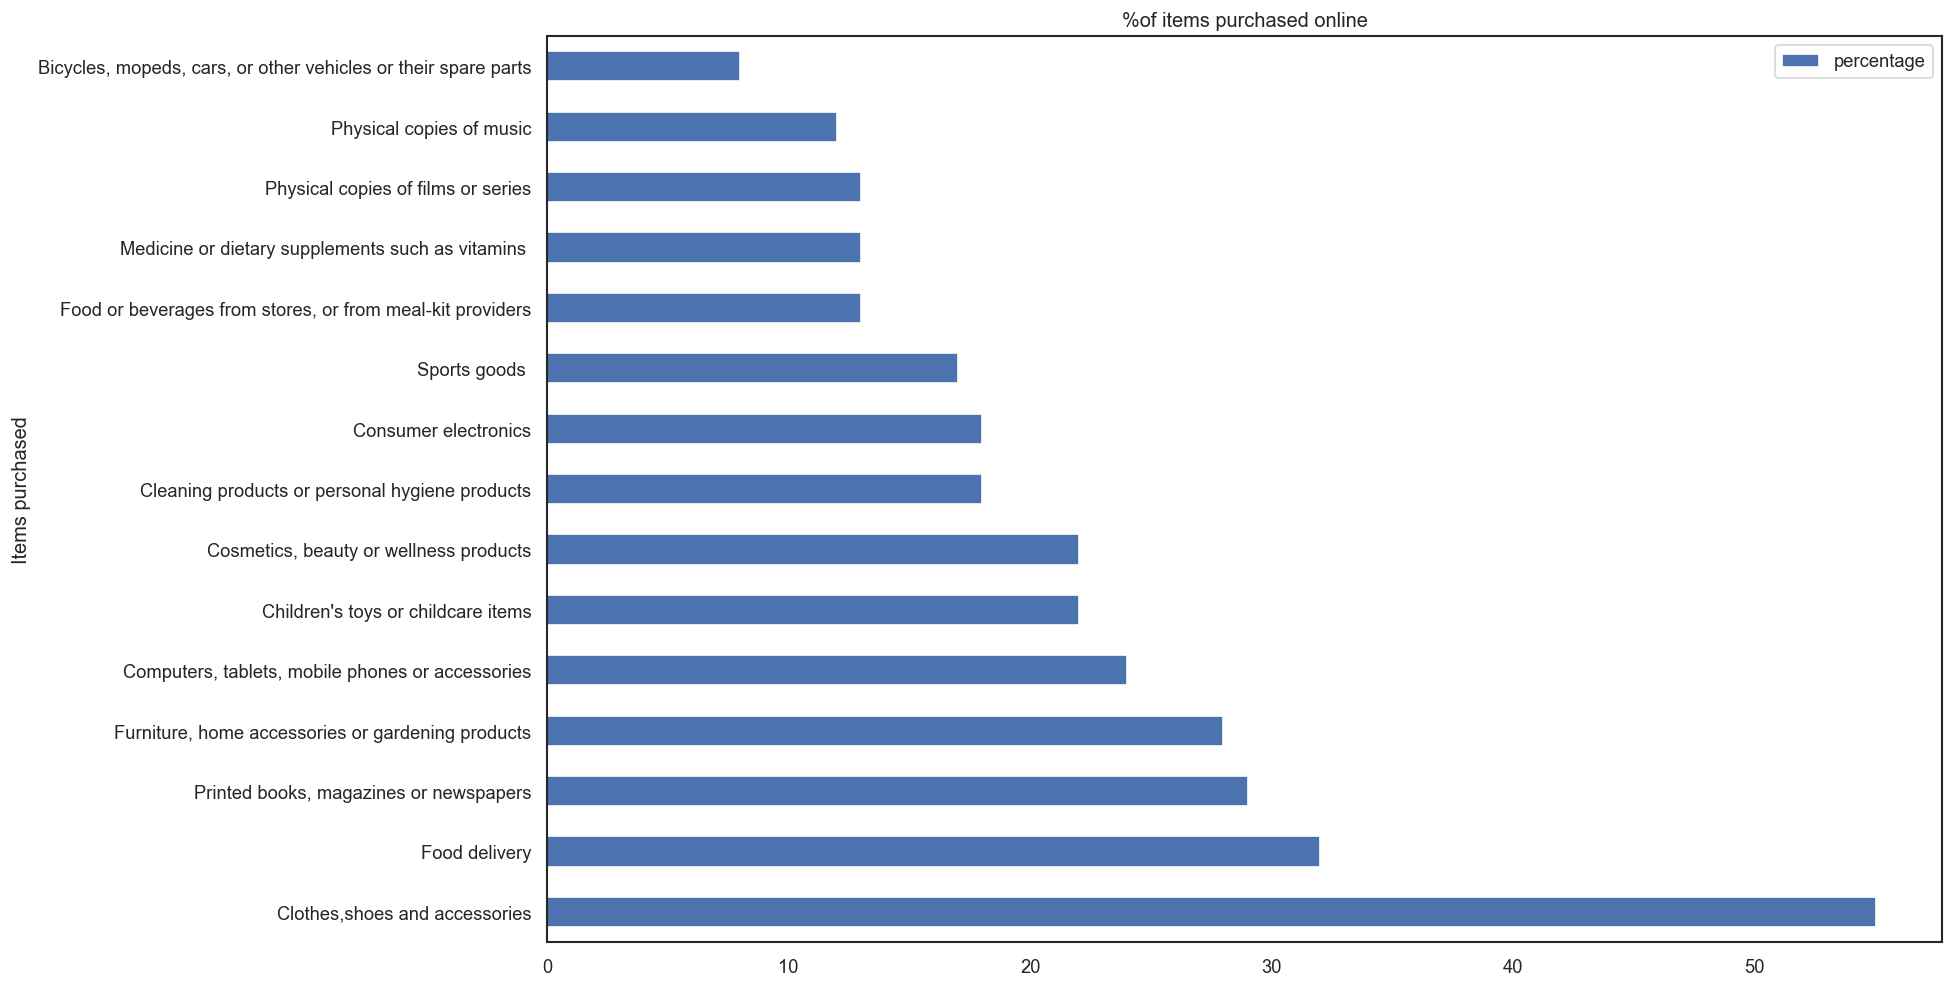

In [343]:
ax=items_purchased_online.plot.barh(y='percentage', x='Items purchased',figsize=(15,10))
ax.set_title('%of items purchased online')

In [344]:
covid_impact_onlineshopping=pd.read_csv('/Users/Apple/Downloads/dataDES/covid impact survey.csv')

In [345]:
covid_impact_onlineshopping

Time period  Buying more online than before  Buying less online than before  \
0      Mar-20                              41                              11   
1      Apr-20                              52                              16   
2      May-20                              58                              13   
3      Jun-20                              63                               9   
4      Aug-20                              62                               8   
5      Jan-21                              70                               7   
6      Feb-21                              71                               5   

   Buying as much online as before  
0                               49  
1                               33  
2                               30  
3                               28  
4                               31  
5                               23  
6                               24

Text(0.5, 1.0, 'Impact of covid-19 on online shopping behaviours')

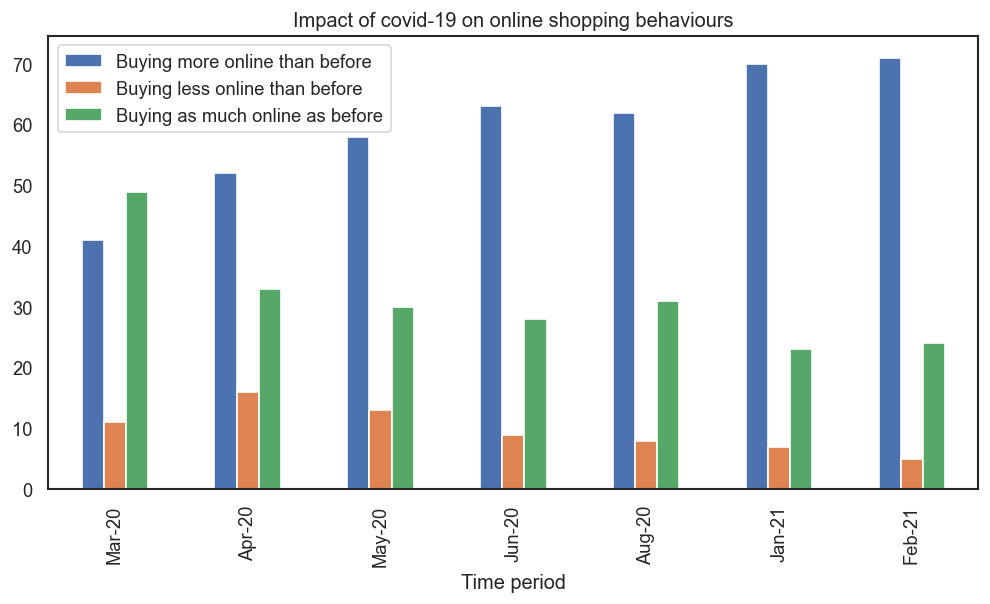

In [346]:
ax=covid_impact_onlineshopping.plot.bar(x='Time period',figsize=(10,5))
ax.set_title('Impact of covid-19 on online shopping behaviours')